In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
import asyncio
import concurrent.futures
from collections import deque
from scipy.optimize import minimize
from pylab import mpl
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import ccxt.async_support as ccxt  # Use asynchronous version
from backtesting import Backtest, Strategy
from colorama import Fore, Style
from tqdm.notebook import tqdm  # Adjusted for Jupyter notebooks

# Suppress TensorFlow and Keras logs
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# If nest_asyncio is not installed, install it
# !pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()  # Allow nested event loops in Jupyter

# Ensure plots display correctly in Jupyter notebooks
%matplotlib inline

warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# -------------------------------------
# 1. Constants and Configuration
# -------------------------------------

SYMBOLS = ['SOL/USDT', 'TON/USDT', 'ENS/USDT', 'NOT/USDT', 'ZK/USDT',
           'ORDI/USDT', 'AVAX/USDT', 'ZRO/USDT', 'NEAR/USDT',
           'SUI/USDT', 'ARB/USDT', 'LINK/USDT', 'UNI/USDT', 'JUP/USDT']

NUM_SYMBOLS = len(SYMBOLS)
PARAMS_PER_SYMBOL = 4  # stop_loss, lower_thresh, upper_thresh, vah_tp_thresh

# -------------------------------------
# 2. Asynchronous Data Fetching Functions
# -------------------------------------

async def fetch_exchange_data(symbol, timeframe, start_date, end_date, limit=1000):
    exchange = ccxt.bybit({
        'enableRateLimit': True,  # Enable rate limiting
    })
    await exchange.load_markets()
    all_ohlcv_data = []
    since = exchange.parse8601(start_date + 'T00:00:00Z')
    end_timestamp = exchange.parse8601(end_date + 'T23:59:59Z')

    timeframe_ms = timeframe_to_milliseconds(timeframe)

    while since < end_timestamp:
        try:
            ohlcv_data = await exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=limit)
            if not ohlcv_data:
                break
            all_ohlcv_data.extend(ohlcv_data)
            since = ohlcv_data[-1][0] + timeframe_ms
            await asyncio.sleep(exchange.rateLimit / 1000)
        except Exception as e:
            # Suppressed error messages for data fetching
            break

    await exchange.close()

    if not all_ohlcv_data:
        return pd.DataFrame()  # Return empty DataFrame if no data

    df = pd.DataFrame(all_ohlcv_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('datetime', inplace=True)
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low',
                       'close': 'Close', 'volume': 'Volume'}, inplace=True)
    return df

def timeframe_to_milliseconds(timeframe):
    """
    Convert a timeframe string to milliseconds.
    Example: '1m' -> 60000
             '5m' -> 300000
             '1h' -> 3600000
    """
    unit = timeframe[-1]
    value = int(timeframe[:-1])
    if unit == 'm':
        return value * 60 * 1000
    elif unit == 'h':
        return value * 60 * 60 * 1000
    elif unit == 'd':
        return value * 24 * 60 * 60 * 1000
    elif unit == 'w':
        return value * 7 * 24 * 60 * 60 * 1000
    elif unit == 'M':
        return value * 30 * 24 * 60 * 60 * 1000  # Approximation
    else:
        raise ValueError(f"Unknown timeframe unit: {unit}")

async def fetch_all_data(symbols, timeframe, start_date, end_date):
    tasks = []
    for symbol in symbols:
        task = fetch_exchange_data(symbol, timeframe, start_date, end_date)
        tasks.append(task)
    data_list = await asyncio.gather(*tasks)
    # Map symbols to their respective DataFrames
    return dict(zip(symbols, data_list))

# -------------------------------------
# 3. Calculating Volume Profile
# -------------------------------------

def calculate_volume_profile(data):
    """
    Calculate Volume Area High (VAH), Value Area Low (VAL), and Point of Control (POC) for each day.
    """
    profile = pd.DataFrame(index=data.resample('1D').mean().index)

    def calculate_vah_val_poc(df):
        if df.empty or df['Volume'].sum() == 0:
            return np.nan, np.nan, np.nan

        total_volume = df['Volume'].sum()
        price_sorted = df.sort_values(by='Close').copy()
        price_sorted['CumVolume'] = price_sorted['Volume'].cumsum()

        # Point of Control (POC): Price with the highest volume
        poc_index = df['Volume'].idxmax()
        poc_price = df.loc[poc_index, 'Close']

        # Value Area High (VAH): Price where cumulative volume >= 68% of total volume
        try:
            vah_idx = price_sorted[price_sorted['CumVolume'] >= total_volume * 0.68].index[0]
            vah_price = price_sorted.loc[vah_idx, 'High']
        except IndexError:
            vah_price = np.nan

        # Value Area Low (VAL): Price where cumulative volume <= 32% of total volume
        try:
            val_idx = price_sorted[price_sorted['CumVolume'] <= total_volume * 0.32].index[-1]
            val_price = price_sorted.loc[val_idx, 'Low']
        except IndexError:
            val_price = np.nan

        return vah_price, val_price, poc_price

    # Apply the function to each day
    result = data.groupby(pd.Grouper(freq='1D')).apply(calculate_vah_val_poc)
    profile[['VAH', 'VAL', 'POC']] = pd.DataFrame(result.tolist(), index=profile.index)

    return profile

# -------------------------------------
# 4. Strategy Definition
# -------------------------------------

class BaseVALtoVAHStrategy(Strategy):
    """
    Trading strategy based on Value Area Low (VAL) and Value Area High (VAH).
    """

    stop_loss = 0.01  # 1%
    lower_thresh = -0.005  # -0.5%
    upper_thresh = -0.004  # -0.4%
    vah_tp_thresh = 0.01  # 1%

    def init(self):
        # Initialize indicators
        self.val = self.I(lambda: self.data.df['VAL'])
        self.vah = self.I(lambda: self.data.df['VAH'])
        self.entry_price = None

    def next(self):
        current_price = self.data.Close[-1]

        val = self.val[-1]
        vah = self.vah[-1]

        # Skip iteration if VAL or VAH is NaN
        if np.isnan(val) or np.isnan(vah):
            return

        lower_bound = val * (1 + self.lower_thresh)
        upper_bound = val * (1 + self.upper_thresh)
        vah_tp = vah * (1 + self.vah_tp_thresh)

        # Ensure lower_bound < upper_bound
        if lower_bound > upper_bound:
            lower_bound, upper_bound = upper_bound, lower_bound

        # Entry condition
        if not self.position and lower_bound <= current_price <= upper_bound:
            self.entry_price = current_price
            self.buy(sl=self.entry_price * (1 - self.stop_loss))

        # Take Profit condition
        if self.position and self.entry_price:
            if current_price >= vah_tp:
                self.position.close()

# -------------------------------------
# 5. Investing Environment and Agent
# -------------------------------------

class Investing:
    def __init__(self, symbols, data_dict, steps=252, amount=1):
        self.symbols = symbols
        self.data_dict = data_dict
        self.steps = steps
        self.initial_balance = amount
        self.portfolio_value = amount
        self.portfolio_value_new = amount
        self.action_space = action_space(len(symbols))
        self.observation_space = observation_space(len(symbols) * 2)  # Adjusted for multiple assets
        self.retrieved = True
        self._generate_data()
        self.portfolios = pd.DataFrame()
        self.episode = 0

    def _generate_data(self):
        # Prepare data for each symbol
        self.data = {}
        for symbol in self.symbols:
            df = self.data_dict[symbol]
            if df.empty:
                continue
            df = df.copy()
            df['X'] = df['Close']
            df = df[['X']]
            if len(df) < self.steps:
                continue  # Skip symbols with insufficient data
            s = random.randint(self.steps, len(df))
            df = df.iloc[s - self.steps:s]
            df = df / df.iloc[0]
            self.data[symbol] = df

    def _get_state(self):
        state = []
        dates = []
        for symbol in self.symbols:
            if symbol not in self.data or self.bar >= len(self.data[symbol]):
                state.extend([0, 0])  # Placeholder for missing data
                dates.append(None)
                continue
            Xt = self.data[symbol]['X'].iloc[self.bar]
            date = self.data[symbol].index[self.bar]
            state.extend([Xt, self.xt.get(symbol, 0)])
            dates.append(date)
        # Use the first non-None date as the current date
        date = next((d for d in dates if d is not None), None)
        return np.array(state), {'date': date}

    def seed(self, seed=None):
        if seed is not None:
            random.seed(seed)

    def reset(self):
        self.xt = {}
        self.bar = 0
        self.treward = 0
        self.portfolio_value = self.initial_balance
        self.portfolio_value_new = self.initial_balance
        self.episode += 1
        self._generate_data()
        self.state, info = self._get_state()
        return self.state, info

    def add_results(self, pl):
        df = pd.DataFrame({
            'e': self.episode,
            'date': self.date,
            'xt': [self.xt.copy()],
            'pv': self.portfolio_value,
            'pv_new': self.portfolio_value_new,
            'p&l[$]': pl,
            'p&l[%]': pl / self.portfolio_value_new * 100 if self.portfolio_value_new != 0 else 0,
        }, index=[0])
        self.portfolios = pd.concat((self.portfolios, df), ignore_index=True)

    def step(self, action):
        self.bar += 1
        self.new_state, info = self._get_state()
        self.date = info['date']
        if self.bar == 1:
            self.xt = {symbol: action[i] for i, symbol in enumerate(self.symbols)}
            pl = 0.
            reward = 0.
            self.add_results(pl)
        else:
            self.portfolio_value_new = 0
            for i, symbol in enumerate(self.symbols):
                if symbol not in self.data or self.bar >= len(self.data[symbol]):
                    continue
                prev_price = self.data[symbol]['X'].iloc[self.bar - 1]
                new_price = self.data[symbol]['X'].iloc[self.bar]
                allocation = self.xt.get(symbol, 0)
                self.portfolio_value_new += allocation * self.portfolio_value * new_price / prev_price

            pl = self.portfolio_value_new - self.portfolio_value
            pen = sum((self.xt.get(symbol, 0) - action[i]) ** 2 for i, symbol in enumerate(self.symbols))
            self.xt = {symbol: action[i] for i, symbol in enumerate(self.symbols)}
            self.add_results(pl)
            ret = self.portfolios['p&l[%]'].iloc[-1] / 100 * 252
            vol = self.portfolios['p&l[%]'].rolling(
                20, min_periods=1).std().iloc[-1] * math.sqrt(252)
            sharpe = ret / vol if vol != 0 else 0
            reward = sharpe - pen
            self.portfolio_value = self.portfolio_value_new
        if self.bar >= self.steps - 1:
            done = True
        else:
            done = False
        self.state = self.new_state
        return self.state, reward, done, False, {}

class observation_space:
    def __init__(self, n):
        self.shape = (n,)

class action_space:
    def __init__(self, n):
        self.n = n

    def seed(self, seed):
        random.seed(seed)

    def sample(self):
        rn = np.random.random(self.n)
        return rn / rn.sum()

# -------------------------------------
# 6. Investing Agent
# -------------------------------------

class InvestingAgent:
    def __init__(self, symbol, feature, n_features, env, hu=128, lr=0.00025):
        self.epsilon = 1.0
        self.epsilon_decay = 0.9975
        self.epsilon_min = 0.1
        self.memory = deque(maxlen=2000)
        self.batch_size = 32
        self.gamma = 0.5
        self.trewards = list()
        self.max_treward = -np.inf
        self.n_features = n_features
        self.env = env
        self.episodes = 0
        self._create_model(hu, lr)

    def _create_model(self, hu, lr):
        self.model = Sequential()
        self.model.add(Dense(hu, activation='relu',
                             input_dim=self.n_features))
        self.model.add(Dense(hu, activation='relu'))
        self.model.add(Dense(len(self.env.symbols), activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(learning_rate=lr))

    def _reshape(self, state):
        state = state.flatten()
        return np.reshape(state, [1, len(state)])

    def opt_action(self, state):
        bnds = len(self.env.symbols) * [(0, 1)]
        cons = [{'type': 'eq', 'fun': lambda x: x.sum() - 1}]
        def f(x):
            s = state.copy()
            for i in range(len(self.env.symbols)):
                s[0, i * 2 + 1] = x[i]  # Adjust index based on state structure
            pen = np.mean((state[0, 1::2] - x) ** 2)
            pred = self.model.predict(s, verbose=0)[0]
            return -np.sum(pred) + pen
        try:
            state = self._reshape(state)
            res = minimize(f,
                           len(self.env.symbols) * [1 / len(self.env.symbols)],
                           bounds=bnds,
                           constraints=cons,
                           options={'eps': 1e-4},
                           method='SLSQP')
            self.action = res.x
        except Exception as e:
            # Suppress optimization errors
            self.action = np.ones(len(self.env.symbols)) / len(self.env.symbols)
        return self.action

    def act(self, state):
        if random.random() <= self.epsilon:
            return self.env.action_space.sample()
        action = self.opt_action(state)
        return action

    def replay(self):
        batch = random.sample(self.memory, min(len(self.memory), self.batch_size))
        for state, action, next_state, reward, done in batch:
            target = reward
            if not done:
                ns = next_state.copy()
                next_action = self.opt_action(ns)
                for i in range(len(self.env.symbols)):
                    ns[0, i * 2 + 1] = next_action[i]
                target += self.gamma * np.sum(self.model.predict(ns, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        progress_bar = tqdm(range(1, episodes + 1), desc="Training episodes", leave=True)  # Added progress bar
        for e in progress_bar:
            self.episodes += 1
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for f in range(1, 5000):
                self.f = f
                action = self.act(state)
                next_state, reward, done, trunc, _ = self.env.step(action)
                treward += reward
                next_state = self._reshape(next_state)
                self.memory.append(
                    [state, action, next_state, reward, done])
                state = next_state
                if done:
                    self.trewards.append(treward)
                    self.max_treward = max(self.max_treward, treward)
                    # Update progress bar with current rewards
                    progress_bar.set_postfix({'treward': f'{treward:.3f}', 'max': f'{self.max_treward:.3f}'})
                    break
            if len(self.memory) > self.batch_size:
                self.replay()
        print()

    def test(self, episodes, verbose=True):
        progress_bar = tqdm(range(1, episodes + 1), desc="Testing episodes", leave=True)  # Added progress bar
        for e in progress_bar:
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for _ in range(1, len(self.env.data[self.env.symbols[0]]) + 1):
                action = self.opt_action(state)
                state, reward, done, trunc, _ = self.env.step(action)
                state = self._reshape(state)
                treward += reward
                if done:
                    progress_bar.set_postfix({'treward': f'{treward:.2f}'})
                    if verbose:
                        print(f"Episode {e}: Total reward = {treward:.2f}")
                    break
        print()

# -------------------------------------
# 7. Main function to run everything
# -------------------------------------

async def main():
    timeframe = '1h'  # Adjusted timeframe
    start_date = (dt.datetime.now() - dt.timedelta(weeks=24)).strftime('%Y-%m-%d')  # Use 24 weeks of data
    end_date = dt.datetime.now().strftime('%Y-%m-%d')

    data_dict = await fetch_all_data(SYMBOLS, timeframe, start_date, end_date)

    # Parallelized Volume Profile Calculations
    def process_symbol(symbol_data):
        symbol, data = symbol_data
        if data.empty:
            return symbol, data
        profile_data = calculate_volume_profile(data)
        data[['VAH', 'VAL', 'POC']] = profile_data[['VAH', 'VAL', 'POC']]
        data.ffill(inplace=True)
        return symbol, data

    # Prepare list of symbol-data pairs
    symbol_data_list = list(data_dict.items())

    # Process volume profiles in parallel with progress bar
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_symbol, symbol_data_list), total=len(symbol_data_list), desc="Processing symbols"))
        data_dict = dict(results)

    # Prepare the environment and agent
    investing = Investing(SYMBOLS, data_dict, steps=252, amount=1)
    agent = InvestingAgent('MultiAsset', feature=None, n_features=investing.observation_space.shape[0],
                           env=investing, hu=128, lr=0.00025)

    # Train the agent
    episodes = 50
    print(f"{Fore.GREEN}Starting training of the Investing Agent...{Style.RESET_ALL}")
    agent.learn(episodes)

    # Test the agent
    print(f"{Fore.GREEN}Testing the trained Investing Agent...{Style.RESET_ALL}")
    agent.test(10, verbose=False)

    # Analyze results
    portfolios = agent.env.portfolios
    portfolios.set_index('date', inplace=True)

    # Prepare allocations DataFrame
    allocations_list = portfolios['xt'].tolist()
    # Filter out any missing or incomplete allocation dictionaries
    allocations_list = [alloc for alloc in allocations_list if isinstance(alloc, dict) and len(alloc) == len(SYMBOLS)]
    allocations = pd.DataFrame(allocations_list, index=portfolios.index[:len(allocations_list)])
    allocations = allocations.fillna(0)
    allocations = allocations[list(SYMBOLS)]

    allocations.plot(figsize=(12, 6), title='Asset Allocations Over Time', lw=1)
    plt.xlabel('Date')
    plt.ylabel('Allocation')
    plt.legend(loc='upper right', fontsize='small')
    plt.show()

    # Plot portfolio value
    portfolios['pv_new'].plot(title='Portfolio Value Over Time', lw=1)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.show()

    # Calculate performance metrics
    final_values = portfolios.groupby('e')['pv_new'].last()
    print(f"{Fore.MAGENTA}Average Final Portfolio Value: {final_values.mean():.4f}{Style.RESET_ALL}")

# Since we are in a Jupyter notebook, we can directly await the main function
await main()

2024-11-07 21:23:12.168476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731014592.197330   10449 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731014592.204131   10449 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 21:23:12.226796: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter 

Loading BokehJS ...

Processing symbols:   0%|          | 0/14 [00:00<?, ?it/s]

Starting training of the Investing Agent...


2024-11-07 21:23:47.925029: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Training episodes:   0%|          | 0/50 [00:00<?, ?it/s]

Processing symbols:   0%|          | 0/2 [00:00<?, ?it/s]

Starting training of the Investing Agent...


Training episodes:   0%|          | 0/5 [00:00<?, ?it/s]


Testing the trained Investing Agent...


Testing episodes:   0%|          | 0/2 [00:00<?, ?it/s]

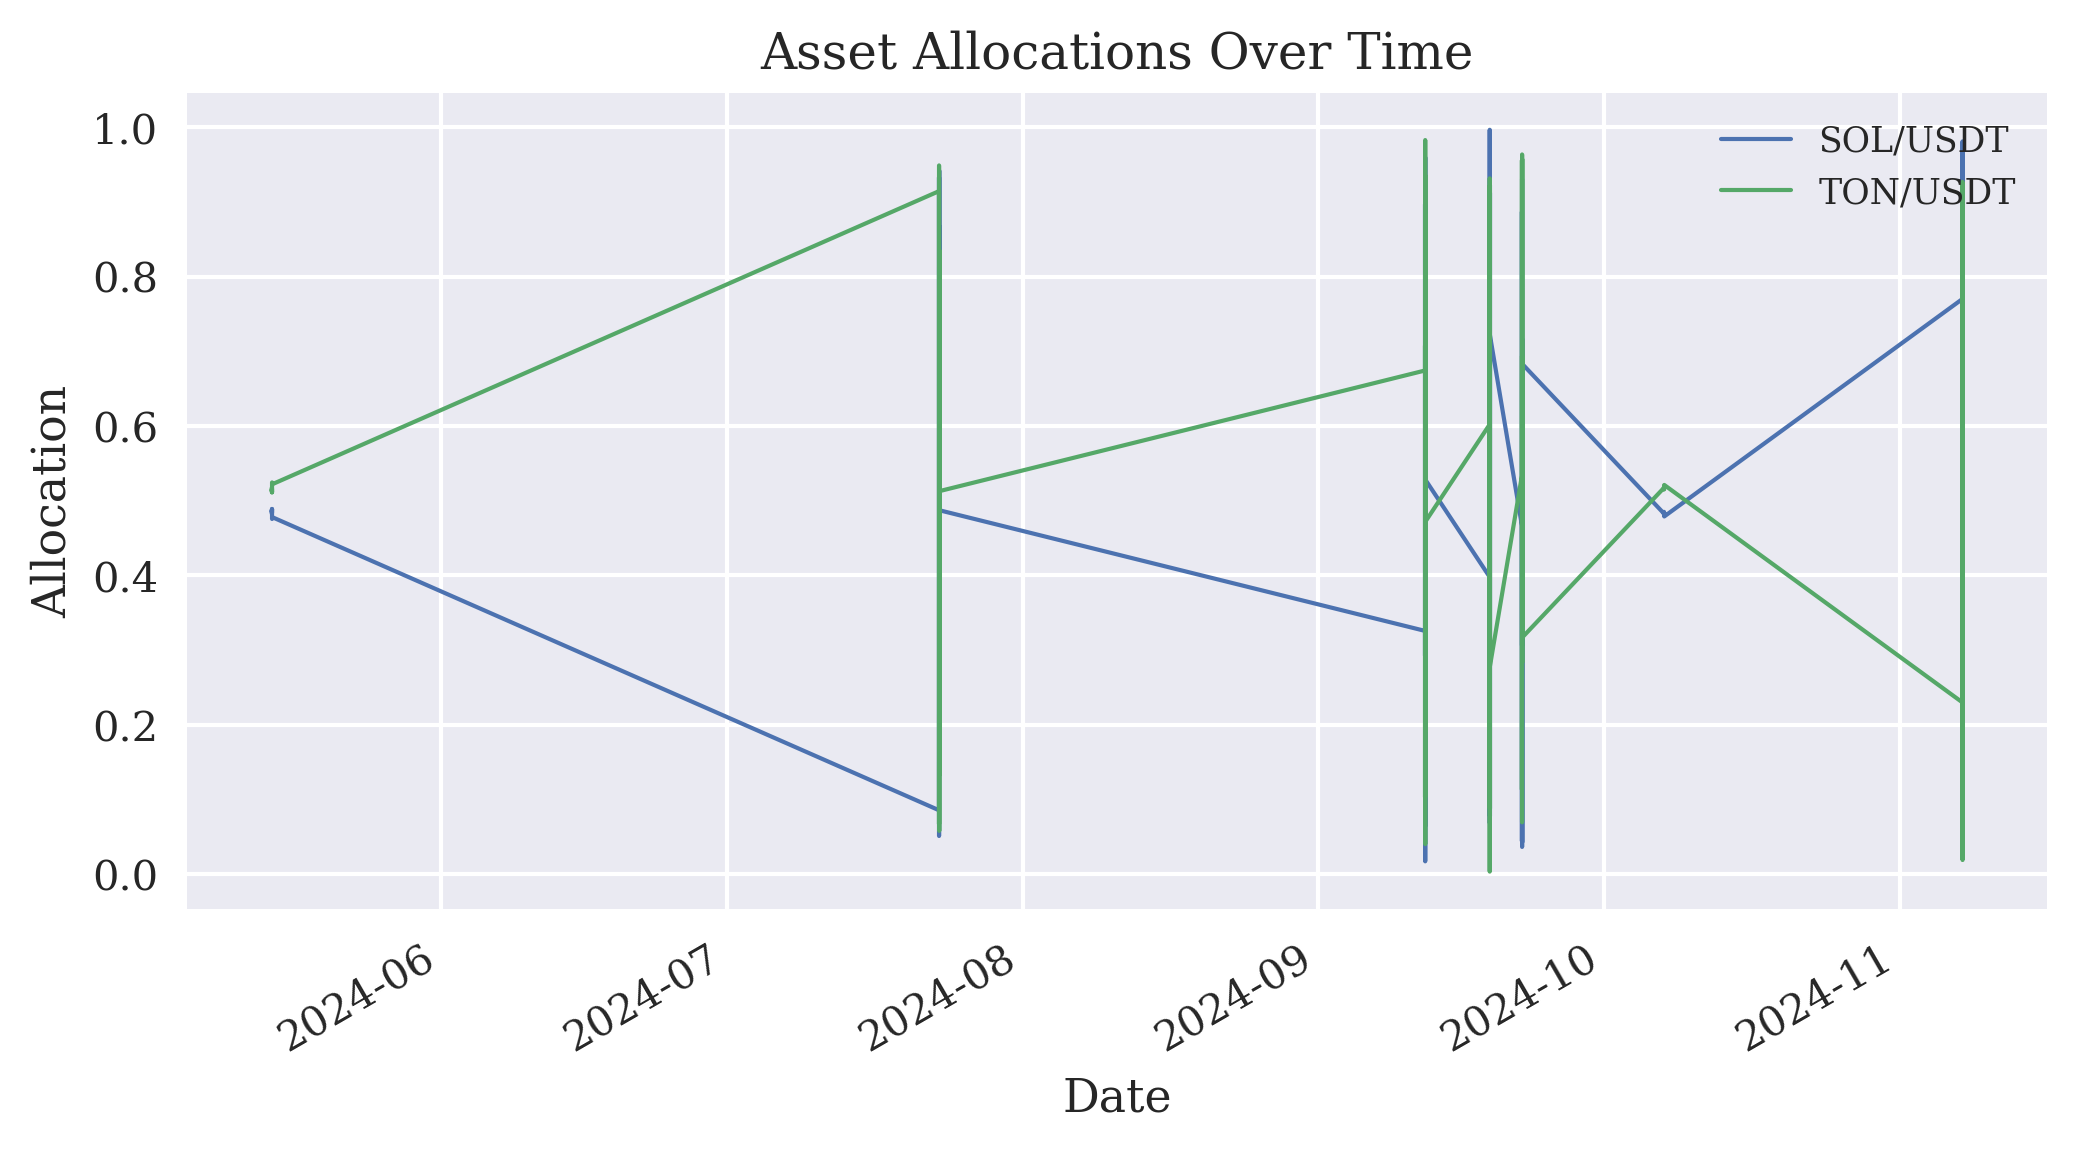

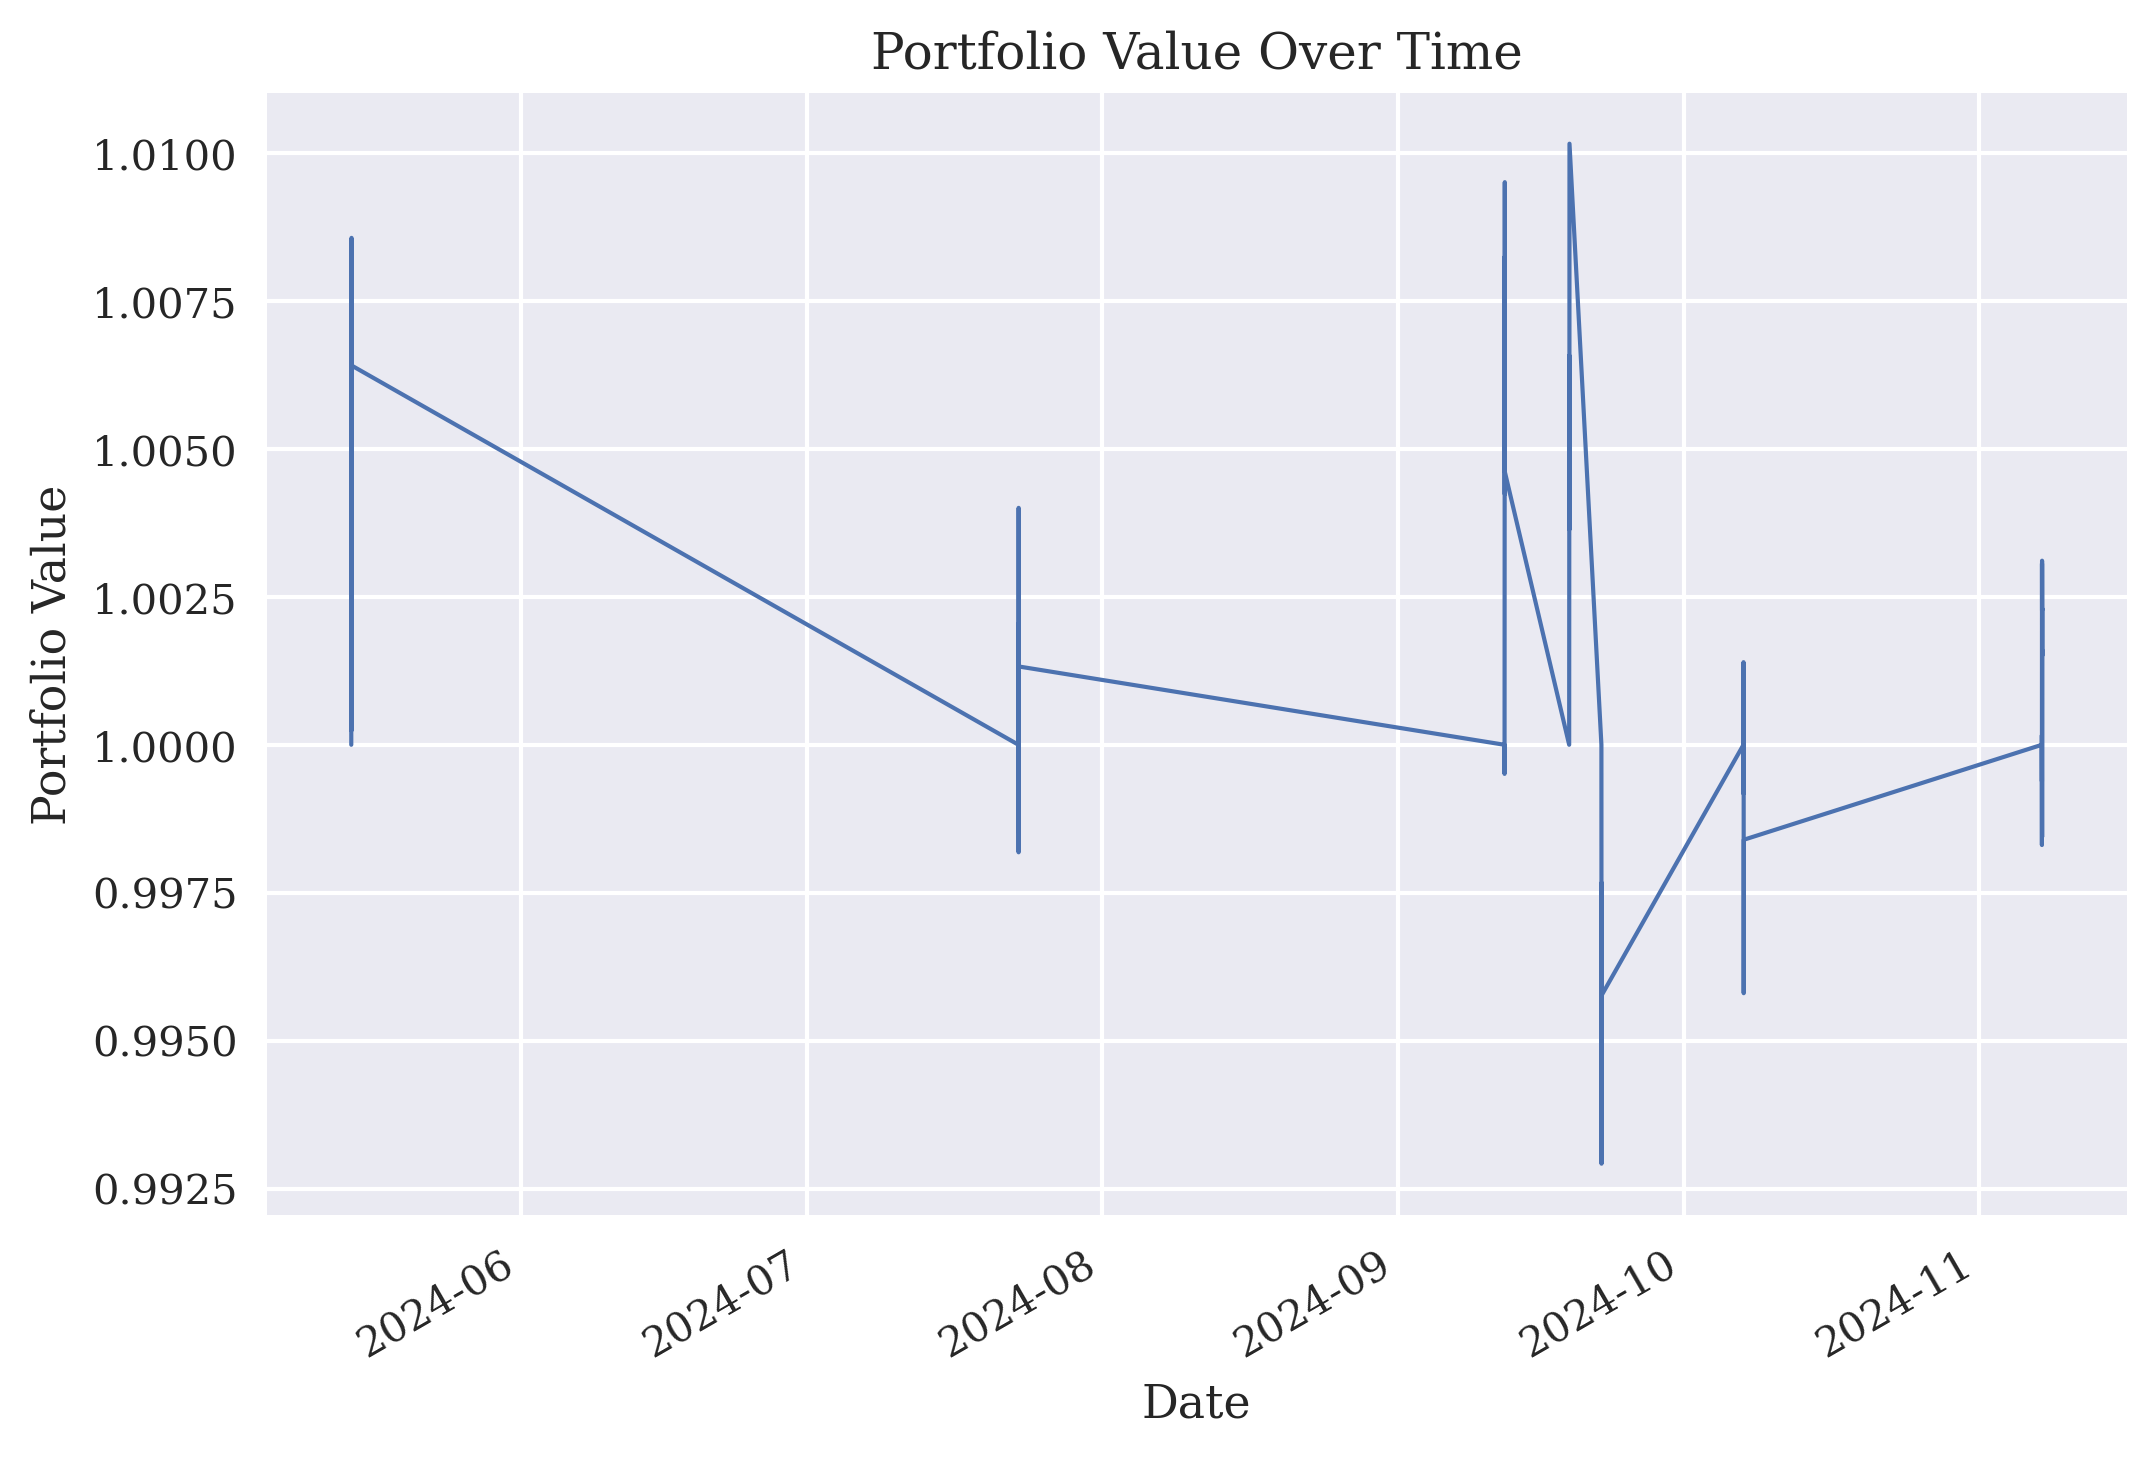

Average Final Portfolio Value: 1.0026


In [2]:
import os
import math
import random
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
import asyncio
import concurrent.futures
from collections import deque
from scipy.optimize import minimize
from pylab import mpl
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import ccxt.async_support as ccxt  # Use asynchronous version
from colorama import Fore, Style
from tqdm.notebook import tqdm  # Adjusted for Jupyter notebooks

# Suppress TensorFlow and Keras logs
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# If nest_asyncio is not installed, install it
# !pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()  # Allow nested event loops in Jupyter

# Ensure plots display correctly in Jupyter notebooks
%matplotlib inline

warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# -------------------------------------
# 1. Constants and Configuration
# -------------------------------------

# Simplified to use only two symbols
SYMBOLS = ['SOL/USDT', 'TON/USDT']

NUM_SYMBOLS = len(SYMBOLS)

# -------------------------------------
# 2. Asynchronous Data Fetching Functions
# -------------------------------------

async def fetch_exchange_data(symbol, timeframe, start_date, end_date, limit=1000):
    exchange = ccxt.bybit({
        'enableRateLimit': True,  # Enable rate limiting
    })
    await exchange.load_markets()
    all_ohlcv_data = []
    since = exchange.parse8601(start_date + 'T00:00:00Z')
    end_timestamp = exchange.parse8601(end_date + 'T23:59:59Z')

    timeframe_ms = timeframe_to_milliseconds(timeframe)

    while since < end_timestamp:
        try:
            ohlcv_data = await exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=limit)
            if not ohlcv_data:
                break
            all_ohlcv_data.extend(ohlcv_data)
            since = ohlcv_data[-1][0] + timeframe_ms
            await asyncio.sleep(exchange.rateLimit / 1000)
        except Exception:
            break

    await exchange.close()

    if not all_ohlcv_data:
        return pd.DataFrame()  # Return empty DataFrame if no data

    df = pd.DataFrame(all_ohlcv_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('datetime', inplace=True)
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low',
                       'close': 'Close', 'volume': 'Volume'}, inplace=True)
    return df

def timeframe_to_milliseconds(timeframe):
    """
    Convert a timeframe string to milliseconds.
    Example: '1m' -> 60000
             '5m' -> 300000
             '1h' -> 3600000
    """
    unit = timeframe[-1]
    value = int(timeframe[:-1])
    if unit == 'm':
        return value * 60 * 1000
    elif unit == 'h':
        return value * 60 * 60 * 1000
    elif unit == 'd':
        return value * 24 * 60 * 60 * 1000
    elif unit == 'w':
        return value * 7 * 24 * 60 * 60 * 1000
    elif unit == 'M':
        return value * 30 * 24 * 60 * 60 * 1000  # Approximation
    else:
        raise ValueError(f"Unknown timeframe unit: {unit}")

async def fetch_all_data(symbols, timeframe, start_date, end_date):
    tasks = []
    for symbol in symbols:
        task = fetch_exchange_data(symbol, timeframe, start_date, end_date)
        tasks.append(task)
    data_list = await asyncio.gather(*tasks)
    # Map symbols to their respective DataFrames
    return dict(zip(symbols, data_list))

# -------------------------------------
# 3. Calculating Volume Profile
# -------------------------------------

def calculate_volume_profile(data):
    """
    Calculate Volume Area High (VAH), Value Area Low (VAL), and Point of Control (POC) for each day.
    """
    profile = pd.DataFrame(index=data.resample('1D').mean().index)

    def calculate_vah_val_poc(df):
        if df.empty or df['Volume'].sum() == 0:
            return np.nan, np.nan, np.nan

        total_volume = df['Volume'].sum()
        price_sorted = df.sort_values(by='Close').copy()
        price_sorted['CumVolume'] = price_sorted['Volume'].cumsum()

        # Point of Control (POC): Price with the highest volume
        poc_index = df['Volume'].idxmax()
        poc_price = df.loc[poc_index, 'Close']

        # Value Area High (VAH): Price where cumulative volume >= 68% of total volume
        try:
            vah_idx = price_sorted[price_sorted['CumVolume'] >= total_volume * 0.68].index[0]
            vah_price = price_sorted.loc[vah_idx, 'High']
        except IndexError:
            vah_price = np.nan

        # Value Area Low (VAL): Price where cumulative volume <= 32% of total volume
        try:
            val_idx = price_sorted[price_sorted['CumVolume'] <= total_volume * 0.32].index[-1]
            val_price = price_sorted.loc[val_idx, 'Low']
        except IndexError:
            val_price = np.nan

        return vah_price, val_price, poc_price

    # Apply the function to each day
    result = data.groupby(pd.Grouper(freq='1D')).apply(calculate_vah_val_poc)
    profile[['VAH', 'VAL', 'POC']] = pd.DataFrame(result.tolist(), index=profile.index)

    return profile

# -------------------------------------
# 4. Investing Environment and Agent
# -------------------------------------

class Investing:
    def __init__(self, symbols, data_dict, steps=50, amount=1):
        self.symbols = symbols
        self.data_dict = data_dict
        self.steps = steps
        self.initial_balance = amount
        self.portfolio_value = amount
        self.portfolio_value_new = amount
        self.action_space = action_space(len(symbols))
        self.observation_space = observation_space(len(symbols) * 2)  # Adjusted for multiple assets
        self.retrieved = True
        self._generate_data()
        self.portfolios = pd.DataFrame()
        self.episode = 0

    def _generate_data(self):
        # Prepare data for each symbol
        self.data = {}
        for symbol in self.symbols:
            df = self.data_dict[symbol]
            if df.empty:
                continue
            df = df.copy()
            df['X'] = df['Close']
            df = df[['X']]
            if len(df) < self.steps:
                continue  # Skip symbols with insufficient data
            s = random.randint(self.steps, len(df))
            df = df.iloc[s - self.steps:s]
            df = df / df.iloc[0]
            self.data[symbol] = df

    def _get_state(self):
        state = []
        dates = []
        for symbol in self.symbols:
            if symbol not in self.data or self.bar >= len(self.data[symbol]):
                state.extend([0, 0])  # Placeholder for missing data
                dates.append(None)
                continue
            Xt = self.data[symbol]['X'].iloc[self.bar]
            date = self.data[symbol].index[self.bar]
            state.extend([Xt, self.xt.get(symbol, 0)])
            dates.append(date)
        # Use the first non-None date as the current date
        date = next((d for d in dates if d is not None), None)
        return np.array(state), {'date': date}

    def seed(self, seed=None):
        if seed is not None:
            random.seed(seed)

    def reset(self):
        self.xt = {}
        self.bar = 0
        self.treward = 0
        self.portfolio_value = self.initial_balance
        self.portfolio_value_new = self.initial_balance
        self.episode += 1
        self._generate_data()
        self.state, info = self._get_state()
        return self.state, info

    def add_results(self, pl):
        df = pd.DataFrame({
            'e': self.episode,
            'date': self.date,
            'xt': [self.xt.copy()],
            'pv': self.portfolio_value,
            'pv_new': self.portfolio_value_new,
            'p&l[$]': pl,
            'p&l[%]': pl / self.portfolio_value_new * 100 if self.portfolio_value_new != 0 else 0,
        }, index=[0])
        self.portfolios = pd.concat((self.portfolios, df), ignore_index=True)

    def step(self, action):
        self.bar += 1
        self.new_state, info = self._get_state()
        self.date = info['date']
        if self.bar == 1:
            self.xt = {symbol: action[i] for i, symbol in enumerate(self.symbols)}
            pl = 0.
            reward = 0.
            self.add_results(pl)
        else:
            self.portfolio_value_new = 0
            for i, symbol in enumerate(self.symbols):
                if symbol not in self.data or self.bar >= len(self.data[symbol]):
                    continue
                prev_price = self.data[symbol]['X'].iloc[self.bar - 1]
                new_price = self.data[symbol]['X'].iloc[self.bar]
                allocation = self.xt.get(symbol, 0)
                self.portfolio_value_new += allocation * self.portfolio_value * new_price / prev_price

            pl = self.portfolio_value_new - self.portfolio_value
            pen = sum((self.xt.get(symbol, 0) - action[i]) ** 2 for i, symbol in enumerate(self.symbols))
            self.xt = {symbol: action[i] for i, symbol in enumerate(self.symbols)}
            self.add_results(pl)
            ret = self.portfolios['p&l[%]'].iloc[-1] / 100 * 252
            vol = self.portfolios['p&l[%]'].rolling(
                20, min_periods=1).std().iloc[-1] * math.sqrt(252)
            sharpe = ret / vol if vol != 0 else 0
            reward = sharpe - pen
            self.portfolio_value = self.portfolio_value_new
        if self.bar >= self.steps - 1:
            done = True
        else:
            done = False
        self.state = self.new_state
        return self.state, reward, done, False, {}

class observation_space:
    def __init__(self, n):
        self.shape = (n,)

class action_space:
    def __init__(self, n):
        self.n = n

    def seed(self, seed):
        random.seed(seed)

    def sample(self):
        rn = np.random.random(self.n)
        return rn / rn.sum()

# -------------------------------------
# 5. Investing Agent
# -------------------------------------

class InvestingAgent:
    def __init__(self, symbol, feature, n_features, env, hu=32, lr=0.00025):
        self.epsilon = 1.0
        self.epsilon_decay = 0.9975
        self.epsilon_min = 0.1
        self.memory = deque(maxlen=2000)
        self.batch_size = 32
        self.gamma = 0.5
        self.trewards = list()
        self.max_treward = -np.inf
        self.n_features = n_features
        self.env = env
        self.episodes = 0
        self._create_model(hu, lr)

    def _create_model(self, hu, lr):
        self.model = Sequential()
        self.model.add(Dense(hu, activation='relu',
                             input_dim=self.n_features))
        self.model.add(Dense(hu, activation='relu'))
        self.model.add(Dense(len(self.env.symbols), activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(learning_rate=lr))

    def _reshape(self, state):
        state = state.flatten()
        return np.reshape(state, [1, len(state)])

    def opt_action(self, state):
        bnds = len(self.env.symbols) * [(0, 1)]
        cons = [{'type': 'eq', 'fun': lambda x: x.sum() - 1}]
        def f(x):
            s = state.copy()
            for i in range(len(self.env.symbols)):
                s[0, i * 2 + 1] = x[i]  # Adjust index based on state structure
            pen = np.mean((state[0, 1::2] - x) ** 2)
            pred = self.model.predict(s, verbose=0)[0]
            return -np.sum(pred) + pen
        try:
            state = self._reshape(state)
            res = minimize(f,
                           len(self.env.symbols) * [1 / len(self.env.symbols)],
                           bounds=bnds,
                           constraints=cons,
                           options={'eps': 1e-4},
                           method='SLSQP')
            self.action = res.x
        except Exception:
            self.action = np.ones(len(self.env.symbols)) / len(self.env.symbols)
        return self.action

    def act(self, state):
        if random.random() <= self.epsilon:
            return self.env.action_space.sample()
        action = self.opt_action(state)
        return action

    def replay(self):
        batch = random.sample(self.memory, min(len(self.memory), self.batch_size))
        for state, action, next_state, reward, done in batch:
            target = reward
            if not done:
                ns = next_state.copy()
                next_action = self.opt_action(ns)
                for i in range(len(self.env.symbols)):
                    ns[0, i * 2 + 1] = next_action[i]
                target += self.gamma * np.sum(self.model.predict(ns, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        progress_bar = tqdm(range(1, episodes + 1), desc="Training episodes", leave=True)
        for e in progress_bar:
            self.episodes += 1
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for f in range(1, self.env.steps + 1):
                action = self.act(state)
                next_state, reward, done, trunc, _ = self.env.step(action)
                treward += reward
                next_state = self._reshape(next_state)
                self.memory.append(
                    [state, action, next_state, reward, done])
                state = next_state
                if done:
                    self.trewards.append(treward)
                    self.max_treward = max(self.max_treward, treward)
                    # Update progress bar with current rewards
                    progress_bar.set_postfix({'treward': f'{treward:.3f}', 'max': f'{self.max_treward:.3f}'})
                    break
            if len(self.memory) > self.batch_size:
                self.replay()
        print()

    def test(self, episodes, verbose=True):
        progress_bar = tqdm(range(1, episodes + 1), desc="Testing episodes", leave=True)
        for e in progress_bar:
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for _ in range(1, self.env.steps + 1):
                action = self.opt_action(state)
                state, reward, done, trunc, _ = self.env.step(action)
                state = self._reshape(state)
                treward += reward
                if done:
                    progress_bar.set_postfix({'treward': f'{treward:.2f}'})
                    if verbose:
                        print(f"Episode {e}: Total reward = {treward:.2f}")
                    break
        print()

# -------------------------------------
# 6. Main function to run everything
# -------------------------------------

async def main():
    timeframe = '1m'  # Adjusted timeframe
    start_date = (dt.datetime.now() - dt.timedelta(weeks=30)).strftime('%Y-%m-%d')  # Use 4 weeks of data
    end_date = dt.datetime.now().strftime('%Y-%m-%d')

    data_dict = await fetch_all_data(SYMBOLS, timeframe, start_date, end_date)

    # Parallelized Volume Profile Calculations
    def process_symbol(symbol_data):
        symbol, data = symbol_data
        if data.empty:
            return symbol, data
        profile_data = calculate_volume_profile(data)
        data[['VAH', 'VAL', 'POC']] = profile_data[['VAH', 'VAL', 'POC']]
        data.ffill(inplace=True)
        return symbol, data

    # Prepare list of symbol-data pairs
    symbol_data_list = list(data_dict.items())

    # Process volume profiles in parallel with progress bar
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_symbol, symbol_data_list), total=len(symbol_data_list), desc="Processing symbols"))
        data_dict = dict(results)

    # Prepare the environment and agent
    investing = Investing(SYMBOLS, data_dict, steps=50, amount=1)
    agent = InvestingAgent('MultiAsset', feature=None, n_features=investing.observation_space.shape[0],
                           env=investing, hu=32, lr=0.00025)

    # Train the agent
    episodes = 5  # Reduced number of episodes
    print(f"{Fore.GREEN}Starting training of the Investing Agent...{Style.RESET_ALL}")
    agent.learn(episodes)

    # Test the agent
    print(f"{Fore.GREEN}Testing the trained Investing Agent...{Style.RESET_ALL}")
    agent.test(2, verbose=False)  # Reduced number of test episodes

    # Analyze results
    portfolios = agent.env.portfolios
    portfolios.set_index('date', inplace=True)

    # Prepare allocations DataFrame
    allocations_list = portfolios['xt'].tolist()
    # Filter out any missing or incomplete allocation dictionaries
    allocations_list = [alloc for alloc in allocations_list if isinstance(alloc, dict) and len(alloc) == len(SYMBOLS)]
    allocations = pd.DataFrame(allocations_list, index=portfolios.index[:len(allocations_list)])
    allocations = allocations.fillna(0)
    allocations = allocations[list(SYMBOLS)]

    allocations.plot(figsize=(8, 4), title='Asset Allocations Over Time', lw=1)
    plt.xlabel('Date')
    plt.ylabel('Allocation')
    plt.legend(loc='upper right', fontsize='small')
    plt.show()

    # Plot portfolio value
    portfolios['pv_new'].plot(title='Portfolio Value Over Time', lw=1)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.show()

    # Calculate performance metrics
    final_values = portfolios.groupby('e')['pv_new'].last()
    print(f"{Fore.MAGENTA}Average Final Portfolio Value: {final_values.mean():.4f}{Style.RESET_ALL}")

# Since we are in a Jupyter notebook, we can directly await the main function
await main()

2024-11-07 21:59:25.029089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731016765.062961   23521 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731016765.069487   23521 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 21:59:25.095213: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Processing symbols:   0%|          | 0/1 [00:00<?, ?it/s]

Starting training of the Investing Agent...


2024-11-07 22:00:07.381517: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Training episodes:   0%|          | 0/10 [00:00<?, ?it/s]


Testing the trained Investing Agent...


Testing episodes:   0%|          | 0/5 [00:00<?, ?it/s]

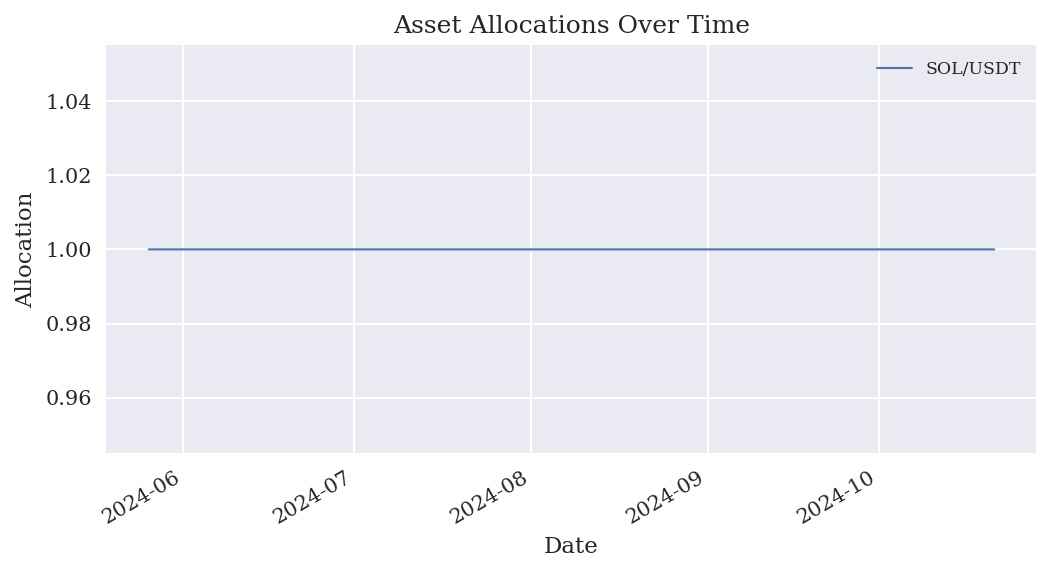

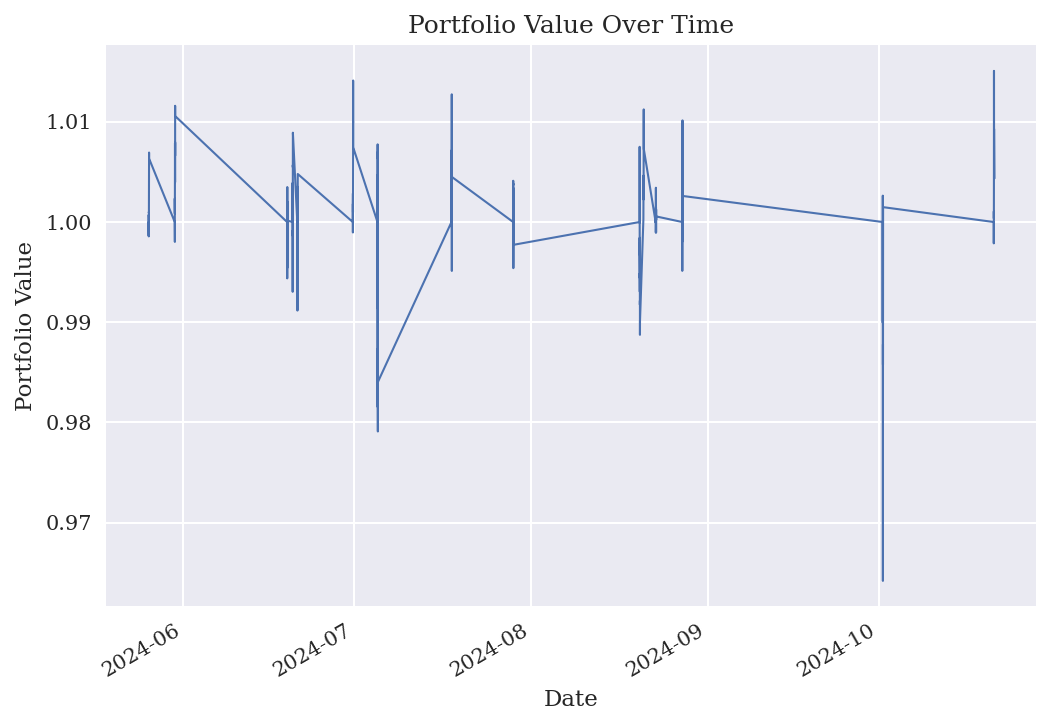

Average Final Portfolio Value: 1.0021


In [1]:
# Import necessary libraries
import os
import math
import random
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
import asyncio
import concurrent.futures
from collections import deque
from scipy.optimize import minimize
from pylab import mpl
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import ccxt.async_support as ccxt  # Use asynchronous version
from colorama import Fore, Style
from tqdm.notebook import tqdm  # For Jupyter notebooks

# Suppress TensorFlow and Keras logs
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Allow nested event loops in Jupyter
import nest_asyncio
nest_asyncio.apply()

# Ensure plots display correctly in Jupyter notebooks
%matplotlib inline

warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# -------------------------------------
# 1. Constants and Configuration
# -------------------------------------

SYMBOLS = ['SOL/USDT']  # You can add more symbols if desired

NUM_SYMBOLS = len(SYMBOLS)

# -------------------------------------
# 2. Asynchronous Data Fetching Functions
# -------------------------------------

async def fetch_exchange_data(symbol, timeframe, start_date, end_date, limit=1000):
    exchange = ccxt.bybit({
        'enableRateLimit': True,  # Enable rate limiting
    })
    await exchange.load_markets()
    all_ohlcv_data = []
    since = exchange.parse8601(start_date + 'T00:00:00Z')
    end_timestamp = exchange.parse8601(end_date + 'T23:59:59Z')

    timeframe_ms = timeframe_to_milliseconds(timeframe)

    while since < end_timestamp:
        try:
            ohlcv_data = await exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=limit)
            if not ohlcv_data:
                break
            all_ohlcv_data.extend(ohlcv_data)
            since = ohlcv_data[-1][0] + timeframe_ms
            await asyncio.sleep(exchange.rateLimit / 1000)
        except Exception:
            break

    await exchange.close()

    if not all_ohlcv_data:
        return pd.DataFrame()  # Return empty DataFrame if no data

    df = pd.DataFrame(all_ohlcv_data, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('datetime', inplace=True)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    return df

def timeframe_to_milliseconds(timeframe):
    """
    Convert a timeframe string to milliseconds.
    Example: '1m' -> 60000
             '5m' -> 300000
             '1h' -> 3600000
    """
    unit = timeframe[-1]
    value = int(timeframe[:-1])
    if unit == 'm':
        return value * 60 * 1000
    elif unit == 'h':
        return value * 60 * 60 * 1000
    elif unit == 'd':
        return value * 24 * 60 * 60 * 1000
    elif unit == 'w':
        return value * 7 * 24 * 60 * 60 * 1000
    elif unit == 'M':
        return value * 30 * 24 * 60 * 60 * 1000  # Approximation
    else:
        raise ValueError(f"Unknown timeframe unit: {unit}")

async def fetch_all_data(symbols, timeframe, start_date, end_date):
    tasks = []
    for symbol in symbols:
        task = fetch_exchange_data(symbol, timeframe, start_date, end_date)
        tasks.append(task)
    data_list = await asyncio.gather(*tasks)
    # Map symbols to their respective DataFrames
    return dict(zip(symbols, data_list))

# -------------------------------------
# 3. Calculating Volume Profile
# -------------------------------------

def calculate_volume_profile(data):
    """
    Calculate Volume Area High (VAH), Value Area Low (VAL), and Point of Control (POC) for each day.
    """
    profile = pd.DataFrame(index=data.resample('1D').mean().index)

    def calculate_vah_val_poc(df):
        if df.empty or df['Volume'].sum() == 0:
            return np.nan, np.nan, np.nan

        total_volume = df['Volume'].sum()
        price_sorted = df.sort_values(by='Close').copy()
        price_sorted['CumVolume'] = price_sorted['Volume'].cumsum()

        # Point of Control (POC): Price with the highest volume
        poc_index = df['Volume'].idxmax()
        poc_price = df.loc[poc_index, 'Close']

        # Value Area High (VAH): Price where cumulative volume >= 68% of total volume
        try:
            vah_idx = price_sorted[price_sorted['CumVolume'] >= total_volume * 0.68].index[0]
            vah_price = df.loc[vah_idx, 'High']
        except IndexError:
            vah_price = np.nan

        # Value Area Low (VAL): Price where cumulative volume <= 32% of total volume
        try:
            val_idx = price_sorted[price_sorted['CumVolume'] <= total_volume * 0.32].index[-1]
            val_price = df.loc[val_idx, 'Low']
        except IndexError:
            val_price = np.nan

        return vah_price, val_price, poc_price

    # Apply the function to each day
    result = data.groupby(pd.Grouper(freq='1D')).apply(calculate_vah_val_poc)
    profile[['VAH', 'VAL', 'POC']] = pd.DataFrame(result.tolist(), index=profile.index)

    return profile

# -------------------------------------
# 4. Investing Environment and Agent
# -------------------------------------

class Investing:
    def __init__(self, symbols, data_dict, steps=252, amount=1):
        self.symbols = symbols
        self.data_dict = data_dict
        self.steps = steps
        self.initial_balance = amount
        self.portfolio_value = amount
        self.portfolio_value_new = amount
        self.action_space = action_space(len(symbols))
        # Adjusted observation space to include features
        self.observation_space = observation_space(len(symbols) * (2 + 3))  # Price, allocation, VAH, VAL, POC
        self.retrieved = True
        self._generate_data()
        self.portfolios = pd.DataFrame()
        self.episode = 0

    def _generate_data(self):
        # Prepare data for each symbol
        self.data = {}
        for symbol in self.symbols:
            df = self.data_dict[symbol]
            if df.empty:
                continue
            df = df.copy()
            df['X'] = df['Close']
            df = df[['X', 'VAH', 'VAL', 'POC']]
            if len(df) < self.steps:
                continue  # Skip symbols with insufficient data
            s = random.randint(self.steps, len(df))
            df = df.iloc[s - self.steps:s]
            # Normalize prices and features
            df[['X', 'VAH', 'VAL', 'POC']] = df[['X', 'VAH', 'VAL', 'POC']] / df['X'].iloc[0]
            self.data[symbol] = df

    def _get_state(self):
        state = []
        dates = []
        for symbol in self.symbols:
            if symbol not in self.data or self.bar >= len(self.data[symbol]):
                # Placeholder for missing data
                state.extend([0] * (2 + 3))
                dates.append(None)
                continue
            row = self.data[symbol].iloc[self.bar]
            Xt = row['X']
            vah = row['VAH']
            val = row['VAL']
            poc = row['POC']
            date = self.data[symbol].index[self.bar]
            state.extend([Xt, self.xt.get(symbol, 0), vah, val, poc])
            dates.append(date)
        # Use the first non-None date as the current date
        date = next((d for d in dates if d is not None), None)
        return np.array(state), {'date': date}

    def seed(self, seed=None):
        if seed is not None:
            random.seed(seed)

    def reset(self):
        self.xt = {}
        self.bar = 0
        self.treward = 0
        self.portfolio_value = self.initial_balance
        self.portfolio_value_new = self.initial_balance
        self.episode += 1
        self._generate_data()
        self.state, info = self._get_state()
        return self.state, info

    def add_results(self, pl):
        df = pd.DataFrame({
            'e': self.episode,
            'date': self.date,
            'xt': [self.xt.copy()],
            'pv': self.portfolio_value,
            'pv_new': self.portfolio_value_new,
            'p&l[$]': pl,
            'p&l[%]': pl / self.portfolio_value_new * 100 if self.portfolio_value_new != 0 else 0,
        }, index=[0])
        self.portfolios = pd.concat((self.portfolios, df), ignore_index=True)

    def step(self, action):
        self.bar += 1
        self.new_state, info = self._get_state()
        self.date = info['date']
        if self.bar == 1:
            self.xt = {symbol: action[i] for i, symbol in enumerate(self.symbols)}
            pl = 0.
            reward = 0.
            self.add_results(pl)
        else:
            self.portfolio_value_new = 0
            for i, symbol in enumerate(self.symbols):
                if symbol not in self.data or self.bar >= len(self.data[symbol]):
                    continue
                prev_price = self.data[symbol]['X'].iloc[self.bar - 1]
                new_price = self.data[symbol]['X'].iloc[self.bar]
                allocation = self.xt.get(symbol, 0)
                self.portfolio_value_new += allocation * self.portfolio_value * new_price / prev_price

            pl = self.portfolio_value_new - self.portfolio_value
            pen = sum((self.xt.get(symbol, 0) - action[i]) ** 2 for i, symbol in enumerate(self.symbols))
            self.xt = {symbol: action[i] for i, symbol in enumerate(self.symbols)}
            self.add_results(pl)
            ret = self.portfolios['p&l[%]'].iloc[-1] / 100 * 252
            vol = self.portfolios['p&l[%]'].rolling(
                20, min_periods=1).std().iloc[-1] * math.sqrt(252)
            sharpe = ret / vol if vol != 0 else 0
            reward = sharpe - pen
            self.portfolio_value = self.portfolio_value_new
        if self.bar >= self.steps - 1:
            done = True
        else:
            done = False
        self.state = self.new_state
        return self.state, reward, done, False, {}

class observation_space:
    def __init__(self, n):
        self.shape = (n,)

class action_space:
    def __init__(self, n):
        self.n = n

    def seed(self, seed):
        random.seed(seed)

    def sample(self):
        rn = np.random.random(self.n)
        return rn / rn.sum()

# -------------------------------------
# 5. Investing Agent
# -------------------------------------

class InvestingAgent:
    def __init__(self, symbol, feature, n_features, env, hu=128, lr=0.00025):
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.1
        self.memory = deque(maxlen=2000)
        self.batch_size = 32
        self.gamma = 0.95
        self.trewards = list()
        self.max_treward = -np.inf
        self.n_features = n_features
        self.env = env
        self.episodes = 0
        self._create_model(hu, lr)

    def _create_model(self, hu, lr):
        self.model = Sequential()
        self.model.add(Dense(hu, activation='relu',
                             input_dim=self.n_features))
        self.model.add(Dense(hu, activation='relu'))
        self.model.add(Dense(len(self.env.symbols), activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(learning_rate=lr))

    def _reshape(self, state):
        state = state.flatten()
        return np.reshape(state, [1, len(state)])

    def opt_action(self, state):
        bnds = len(self.env.symbols) * [(0, 1)]
        cons = [{'type': 'eq', 'fun': lambda x: x.sum() - 1}]
        def f(x):
            s = state.copy()
            for i in range(len(self.env.symbols)):
                s[0, i * 5 + 1] = x[i]  # Adjust index based on state structure
            pen = np.mean((state[0, 1::5] - x) ** 2)
            pred = self.model.predict(s, verbose=0)[0]
            return -np.sum(pred) + pen
        try:
            state = self._reshape(state)
            res = minimize(f,
                           len(self.env.symbols) * [1 / len(self.env.symbols)],
                           bounds=bnds,
                           constraints=cons,
                           options={'eps': 1e-4},
                           method='SLSQP')
            self.action = res.x
        except Exception:
            self.action = np.ones(len(self.env.symbols)) / len(self.env.symbols)
        return self.action

    def act(self, state):
        if random.random() <= self.epsilon:
            return self.env.action_space.sample()
        action = self.opt_action(state)
        return action

    def replay(self):
        batch = random.sample(self.memory, min(len(self.memory), self.batch_size))
        for state, action, next_state, reward, done in batch:
            target = reward
            if not done:
                ns = next_state.copy()
                next_action = self.opt_action(ns)
                for i in range(len(self.env.symbols)):
                    ns[0, i * 5 + 1] = next_action[i]
                target += self.gamma * np.sum(self.model.predict(ns, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        progress_bar = tqdm(range(1, episodes + 1), desc="Training episodes", leave=True)
        for e in progress_bar:
            self.episodes += 1
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for f in range(1, self.env.steps + 1):
                action = self.act(state)
                next_state, reward, done, trunc, _ = self.env.step(action)
                treward += reward
                next_state = self._reshape(next_state)
                self.memory.append(
                    [state, action, next_state, reward, done])
                state = next_state
                if done:
                    self.trewards.append(treward)
                    self.max_treward = max(self.max_treward, treward)
                    # Update progress bar with current rewards
                    progress_bar.set_postfix({'treward': f'{treward:.3f}', 'max': f'{self.max_treward:.3f}'})
                    break
            if len(self.memory) > self.batch_size:
                self.replay()
        print()

    def test(self, episodes, verbose=True):
        progress_bar = tqdm(range(1, episodes + 1), desc="Testing episodes", leave=True)
        for e in progress_bar:
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for _ in range(1, self.env.steps + 1):
                action = self.opt_action(state)
                state, reward, done, trunc, _ = self.env.step(action)
                state = self._reshape(state)
                treward += reward
                if done:
                    progress_bar.set_postfix({'treward': f'{treward:.2f}'})
                    if verbose:
                        print(f"Episode {e}: Total reward = {treward:.2f}")
                    break
        print()

# -------------------------------------
# 6. Main function to run everything
# -------------------------------------

async def main():
    timeframe = '1m'  # Adjusted timeframe
    start_date = (dt.datetime.now() - dt.timedelta(weeks=24)).strftime('%Y-%m-%d')  # Use 24 weeks of data
    end_date = dt.datetime.now().strftime('%Y-%m-%d')

    data_dict = await fetch_all_data(SYMBOLS, timeframe, start_date, end_date)

    # Parallelized Volume Profile Calculations
    def process_symbol(symbol_data):
        symbol, data = symbol_data
        if data.empty:
            return symbol, data
        profile_data = calculate_volume_profile(data)
        data[['VAH', 'VAL', 'POC']] = profile_data[['VAH', 'VAL', 'POC']]
        data.ffill(inplace=True)
        return symbol, data

    # Prepare list of symbol-data pairs
    symbol_data_list = list(data_dict.items())

    # Process volume profiles in parallel with progress bar
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_symbol, symbol_data_list), total=len(symbol_data_list), desc="Processing symbols"))
        data_dict = dict(results)

    # Prepare the environment and agent
    investing = Investing(SYMBOLS, data_dict, steps=100, amount=1)
    agent = InvestingAgent('MultiAsset', feature=None, n_features=investing.observation_space.shape[0],
                           env=investing, hu=64, lr=0.00025)

    # Train the agent
    episodes = 10  # Adjust the number of episodes as needed
    print(f"{Fore.GREEN}Starting training of the Investing Agent...{Style.RESET_ALL}")
    agent.learn(episodes)

    # Test the agent
    print(f"{Fore.GREEN}Testing the trained Investing Agent...{Style.RESET_ALL}")
    agent.test(5, verbose=False)  # Adjust the number of test episodes

    # Analyze results
    portfolios = agent.env.portfolios
    portfolios.set_index('date', inplace=True)

    # Prepare allocations DataFrame
    allocations_list = portfolios['xt'].tolist()
    # Filter out any missing or incomplete allocation dictionaries
    allocations_list = [alloc for alloc in allocations_list if isinstance(alloc, dict) and len(alloc) == len(SYMBOLS)]
    allocations = pd.DataFrame(allocations_list, index=portfolios.index[:len(allocations_list)])
    allocations = allocations.fillna(0)
    allocations = allocations[list(SYMBOLS)]

    allocations.plot(figsize=(8, 4), title='Asset Allocations Over Time', lw=1)
    plt.xlabel('Date')
    plt.ylabel('Allocation')
    plt.legend(loc='upper right', fontsize='small')
    plt.show()

    # Plot portfolio value
    portfolios['pv_new'].plot(title='Portfolio Value Over Time', lw=1)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.show()

    # Calculate performance metrics
    final_values = portfolios.groupby('e')['pv_new'].last()
    print(f"{Fore.MAGENTA}Average Final Portfolio Value: {final_values.mean():.4f}{Style.RESET_ALL}")

# Since we are in a Jupyter notebook, we can directly await the main function
await main()

In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
import asyncio
import concurrent.futures
from collections import deque
from scipy.optimize import minimize
from pylab import mpl
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam  # Adjusted import
import ccxt.async_support as ccxt  # Use asynchronous version
from backtesting import Backtest, Strategy
from colorama import Fore, Style
from tqdm.notebook import tqdm  # Adjusted for Jupyter notebooks

# If nest_asyncio is not installed, install it
# !pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()  # Allow nested event loops in Jupyter

# Ensure plots display correctly in Jupyter notebooks
%matplotlib inline

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# -------------------------------------
# 1. Constants and Configuration
# -------------------------------------

SYMBOLS = ['SOL/USDT', 'TON/USDT', 'ENS/USDT', 'NOT/USDT', 'ZK/USDT',
           'ORDI/USDT', 'AVAX/USDT', 'ZRO/USDT', 'NEAR/USDT',
           'SUI/USDT', 'ARB/USDT', 'LINK/USDT', 'UNI/USDT', 'JUP/USDT']

NUM_SYMBOLS = len(SYMBOLS)
PARAMS_PER_SYMBOL = 4  # stop_loss, lower_thresh, upper_thresh, vah_tp_thresh

# -------------------------------------
# 2. Asynchronous Data Fetching Functions
# -------------------------------------

async def fetch_exchange_data(symbol, timeframe, start_date, end_date, limit=1000):
    exchange = ccxt.bybit({
        'enableRateLimit': True,  # Enable rate limiting
    })
    await exchange.load_markets()
    all_ohlcv_data = []
    since = exchange.parse8601(start_date + 'T00:00:00Z')
    end_timestamp = exchange.parse8601(end_date + 'T23:59:59Z')

    timeframe_ms = timeframe_to_milliseconds(timeframe)

    while since < end_timestamp:
        try:
            ohlcv_data = await exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=limit)
            if not ohlcv_data:
                break
            all_ohlcv_data.extend(ohlcv_data)
            since = ohlcv_data[-1][0] + timeframe_ms
            await asyncio.sleep(exchange.rateLimit / 1000)
        except Exception as e:
            print(f"{Fore.RED}Error fetching data for {symbol}: {e}{Style.RESET_ALL}")
            break

    await exchange.close()

    if not all_ohlcv_data:
        print(f"{Fore.RED}No data fetched for {symbol}.{Style.RESET_ALL}")
        return pd.DataFrame()  # Return empty DataFrame if no data

    df = pd.DataFrame(all_ohlcv_data, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('datetime', inplace=True)
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low',
                       'close': 'Close', 'volume': 'Volume'}, inplace=True)
    return df

def timeframe_to_milliseconds(timeframe):
    """
    Convert a timeframe string to milliseconds.
    Example: '1m' -> 60000
             '5m' -> 300000
             '1h' -> 3600000
    """
    unit = timeframe[-1]
    value = int(timeframe[:-1])
    if unit == 'm':
        return value * 60 * 1000
    elif unit == 'h':
        return value * 60 * 60 * 1000
    elif unit == 'd':
        return value * 24 * 60 * 60 * 1000
    elif unit == 'w':
        return value * 7 * 24 * 60 * 60 * 1000
    elif unit == 'M':
        return value * 30 * 24 * 60 * 60 * 1000  # Approximation
    else:
        raise ValueError(f"Unknown timeframe unit: {unit}")

async def fetch_all_data(symbols, timeframe, start_date, end_date):
    tasks = []
    for symbol in symbols:
        task = fetch_exchange_data(symbol, timeframe, start_date, end_date)
        tasks.append(task)
    data_list = await asyncio.gather(*tasks)
    # Map symbols to their respective DataFrames
    return dict(zip(symbols, data_list))

# -------------------------------------
# 3. Calculating Volume Profile
# -------------------------------------

def calculate_volume_profile(data):
    """
    Calculate Volume Area High (VAH), Value Area Low (VAL), and Point of Control (POC) for each day.
    """
    profile = pd.DataFrame(index=data.resample('1D').mean().index)

    def calculate_vah_val_poc(df):
        if df.empty or df['Volume'].sum() == 0:
            return np.nan, np.nan, np.nan

        total_volume = df['Volume'].sum()
        price_sorted = df.sort_values(by='Close').copy()
        price_sorted['CumVolume'] = price_sorted['Volume'].cumsum()

        # Point of Control (POC): Price with the highest volume
        poc_index = df['Volume'].idxmax()
        poc_price = df.loc[poc_index, 'Close']

        # Value Area High (VAH): Price where cumulative volume >= 68% of total volume
        try:
            vah_idx = price_sorted[price_sorted['CumVolume'] >= total_volume * 0.68].index[0]
            vah_price = price_sorted.loc[vah_idx, 'High']
        except IndexError:
            vah_price = np.nan

        # Value Area Low (VAL): Price where cumulative volume <= 32% of total volume
        try:
            val_idx = price_sorted[price_sorted['CumVolume'] <= total_volume * 0.32].index[-1]
            val_price = price_sorted.loc[val_idx, 'Low']
        except IndexError:
            val_price = np.nan

        return vah_price, val_price, poc_price

    # Apply the function to each day
    result = data.groupby(pd.Grouper(freq='1D')).apply(calculate_vah_val_poc)
    profile[['VAH', 'VAL', 'POC']] = pd.DataFrame(result.tolist(), index=profile.index)

    return profile

# -------------------------------------
# 4. Strategy Definition
# -------------------------------------

class BaseVALtoVAHStrategy(Strategy):
    """
    Trading strategy based on Value Area Low (VAL) and Value Area High (VAH).
    """

    stop_loss = 0.01  # 1%
    lower_thresh = -0.005  # -0.5%
    upper_thresh = -0.004  # -0.4%
    vah_tp_thresh = 0.01  # 1%

    def init(self):
        # Initialize indicators
        self.val = self.I(lambda: self.data.df['VAL'])
        self.vah = self.I(lambda: self.data.df['VAH'])
        self.entry_price = None

    def next(self):
        current_price = self.data.Close[-1]

        val = self.val[-1]
        vah = self.vah[-1]

        # Skip iteration if VAL or VAH is NaN
        if np.isnan(val) or np.isnan(vah):
            return

        lower_bound = val * (1 + self.lower_thresh)
        upper_bound = val * (1 + self.upper_thresh)
        vah_tp = vah * (1 + self.vah_tp_thresh)

        # Ensure lower_bound < upper_bound
        if lower_bound > upper_bound:
            lower_bound, upper_bound = upper_bound, lower_bound

        # Entry condition
        if not self.position and lower_bound <= current_price <= upper_bound:
            self.entry_price = current_price
            self.buy(sl=self.entry_price * (1 - self.stop_loss))

        # Take Profit condition
        if self.position and self.entry_price:
            if current_price >= vah_tp:
                self.position.close()

# -------------------------------------
# 5. Investing Environment and Agent
# -------------------------------------

class Investing:
    def __init__(self, symbols, data_dict, steps=252, amount=1):
        self.symbols = symbols
        self.data_dict = data_dict
        self.steps = steps
        self.initial_balance = amount
        self.portfolio_value = amount
        self.portfolio_value_new = amount
        self.action_space = action_space(len(symbols))
        self.observation_space = observation_space(len(symbols) * 2)  # Adjusted for multiple assets
        self.retrieved = True
        self._generate_data()
        self.portfolios = pd.DataFrame()
        self.episode = 0

    def _generate_data(self):
        # Prepare data for each symbol
        self.data = {}
        for symbol in self.symbols:
            df = self.data_dict[symbol]
            if df.empty:
                continue
            df = df.copy()
            df['X'] = df['Close']
            df = df[['X']]
            s = random.randint(self.steps, len(df))
            df = df.iloc[s - self.steps:s]
            df = df / df.iloc[0]
            self.data[symbol] = df

    def _get_state(self):
        state = []
        dates = []
        for symbol in self.symbols:
            if symbol not in self.data or self.bar >= len(self.data[symbol]):
                state.extend([0, 0])  # Placeholder for missing data
                dates.append(None)
                continue
            Xt = self.data[symbol]['X'].iloc[self.bar]
            date = self.data[symbol].index[self.bar]
            state.extend([Xt, self.xt.get(symbol, 0)])
            dates.append(date)
        # Use the first non-None date as the current date
        date = next((d for d in dates if d is not None), None)
        return np.array(state), {'date': date}

    def seed(self, seed=None):
        if seed is not None:
            random.seed(seed)

    def reset(self):
        self.xt = {}
        self.bar = 0
        self.treward = 0
        self.portfolio_value = self.initial_balance
        self.portfolio_value_new = self.initial_balance
        self.episode += 1
        self._generate_data()
        self.state, info = self._get_state()
        return self.state, info

    def add_results(self, pl):
        df = pd.DataFrame({
            'e': self.episode,
            'date': self.date,
            'xt': [self.xt.copy()],
            'pv': self.portfolio_value,
            'pv_new': self.portfolio_value_new,
            'p&l[$]': pl,
            'p&l[%]': pl / self.portfolio_value_new * 100 if self.portfolio_value_new != 0 else 0,
        }, index=[0])
        self.portfolios = pd.concat((self.portfolios, df), ignore_index=True)

    def step(self, action):
        self.bar += 1
        self.new_state, info = self._get_state()
        self.date = info['date']
        if self.bar == 1:
            self.xt = {symbol: action[i] for i, symbol in enumerate(self.symbols)}
            pl = 0.
            reward = 0.
            self.add_results(pl)
        else:
            self.portfolio_value_new = 0
            for i, symbol in enumerate(self.symbols):
                if symbol not in self.data or self.bar >= len(self.data[symbol]):
                    continue
                prev_price = self.data[symbol]['X'].iloc[self.bar - 1]
                new_price = self.data[symbol]['X'].iloc[self.bar]
                allocation = self.xt.get(symbol, 0)
                self.portfolio_value_new += allocation * self.portfolio_value * new_price / prev_price

            pl = self.portfolio_value_new - self.portfolio_value
            pen = sum((self.xt.get(symbol, 0) - action[i]) ** 2 for i, symbol in enumerate(self.symbols))
            self.xt = {symbol: action[i] for i, symbol in enumerate(self.symbols)}
            self.add_results(pl)
            ret = self.portfolios['p&l[%]'].iloc[-1] / 100 * 252
            vol = self.portfolios['p&l[%]'].rolling(
                20, min_periods=1).std().iloc[-1] * math.sqrt(252)
            sharpe = ret / vol if vol != 0 else 0
            reward = sharpe - pen
            self.portfolio_value = self.portfolio_value_new
        if self.bar >= self.steps - 1:
            done = True
        else:
            done = False
        self.state = self.new_state
        return self.state, reward, done, False, {}

class observation_space:
    def __init__(self, n):
        self.shape = (n,)

class action_space:
    def __init__(self, n):
        self.n = n

    def seed(self, seed):
        random.seed(seed)

    def sample(self):
        rn = np.random.random(self.n)
        return rn / rn.sum()

# -------------------------------------
# 6. Investing Agent
# -------------------------------------

class InvestingAgent:
    def __init__(self, symbol, feature, n_features, env, hu=128, lr=0.00025):
        self.epsilon = 1.0
        self.epsilon_decay = 0.9975
        self.epsilon_min = 0.1
        self.memory = deque(maxlen=2000)
        self.batch_size = 32
        self.gamma = 0.5
        self.trewards = list()
        self.max_treward = -np.inf
        self.n_features = n_features
        self.env = env
        self.episodes = 0
        self._create_model(hu, lr)

    def _create_model(self, hu, lr):
        self.model = Sequential()
        self.model.add(Dense(hu, activation='relu',
                             input_dim=self.n_features))
        self.model.add(Dense(hu, activation='relu'))
        self.model.add(Dense(len(self.env.symbols), activation='linear'))
        self.model.compile(loss='mse', optimizer=Adam(learning_rate=lr))  # Adjusted optimizer

    def _reshape(self, state):
        state = state.flatten()
        return np.reshape(state, [1, len(state)])

    def opt_action(self, state):
        bnds = len(self.env.symbols) * [(0, 1)]
        cons = [{'type': 'eq', 'fun': lambda x: x.sum() - 1}]
        def f(x):
            s = state.copy()
            for i in range(len(self.env.symbols)):
                s[0, i * 2 + 1] = x[i]  # Adjust index based on state structure
            pen = np.mean((state[0, 1::2] - x) ** 2)
            pred = self.model.predict(s)[0]
            return -np.sum(pred) + pen
        try:
            state = self._reshape(state)
            res = minimize(f,
                           len(self.env.symbols) * [1 / len(self.env.symbols)],
                           bounds=bnds,
                           constraints=cons,
                           options={'eps': 1e-4},
                           method='SLSQP')
            self.action = res.x
        except Exception as e:
            print(f"Optimization failed: {e}")
            self.action = np.ones(len(self.env.symbols)) / len(self.env.symbols)
        return self.action

    def act(self, state):
        if random.random() <= self.epsilon:
            return self.env.action_space.sample()
        action = self.opt_action(state)
        return action

    def replay(self):
        batch = random.sample(self.memory, min(len(self.memory), self.batch_size))
        for state, action, next_state, reward, done in batch:
            target = reward
            if not done:
                ns = next_state.copy()
                next_action = self.opt_action(ns)
                for i in range(len(self.env.symbols)):
                    ns[0, i * 2 + 1] = next_action[i]
                target += self.gamma * np.sum(self.model.predict(ns)[0])
            target_f = self.model.predict(state)
            target_f[0] = target
            self.model.fit(state, target_f, epochs=1, verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        progress_bar = tqdm(range(1, episodes + 1), desc="Training episodes")  # Added progress bar
        for e in progress_bar:
            self.episodes += 1
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for f in range(1, 5000):
                self.f = f
                action = self.act(state)
                next_state, reward, done, trunc, _ = self.env.step(action)
                treward += reward
                next_state = self._reshape(next_state)
                self.memory.append(
                    [state, action, next_state, reward, done])
                state = next_state
                if done:
                    self.trewards.append(treward)
                    self.max_treward = max(self.max_treward, treward)
                    # Update progress bar with current rewards
                    progress_bar.set_postfix({'treward': f'{treward:.3f}', 'max': f'{self.max_treward:.3f}'})
                    break
            if len(self.memory) > self.batch_size:
                self.replay()
        print()

    def test(self, episodes, verbose=True):
        progress_bar = tqdm(range(1, episodes + 1), desc="Testing episodes")  # Added progress bar
        for e in progress_bar:
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for _ in range(1, len(self.env.data[self.env.symbols[0]]) + 1):
                action = self.opt_action(state)
                state, reward, done, trunc, _ = self.env.step(action)
                state = self._reshape(state)
                treward += reward
                if done:
                    progress_bar.set_postfix({'treward': f'{treward:.2f}'})
                    if verbose:
                        print(f"Episode {e}: Total reward = {treward:.2f}")
                    break
        print()

# -------------------------------------
# 7. Main function to run everything
# -------------------------------------

async def main():
    timeframe = '1h'  # Adjusted timeframe
    start_date = (dt.datetime.now() - dt.timedelta(weeks=24)).strftime('%Y-%m-%d')  # Use 24 weeks of data
    end_date = dt.datetime.now().strftime('%Y-%m-%d')

    print(f"{Fore.BLUE}Fetching data for multiple symbols from {start_date} to {end_date} on a {timeframe} timeframe...{Style.RESET_ALL}")
    data_dict = await fetch_all_data(SYMBOLS, timeframe, start_date, end_date)

    # Parallelized Volume Profile Calculations
    def process_symbol(symbol_data):
        symbol, data = symbol_data
        if data.empty:
            print(f"{Fore.RED}No data available for {symbol}. Skipping volume profile calculation.{Style.RESET_ALL}")
            return symbol, data
        print(f"{Fore.BLUE}Calculating volume profile for {symbol}...{Style.RESET_ALL}")
        profile_data = calculate_volume_profile(data)
        data[['VAH', 'VAL', 'POC']] = profile_data[['VAH', 'VAL', 'POC']]
        data.ffill(inplace=True)
        return symbol, data

    # Prepare list of symbol-data pairs
    symbol_data_list = list(data_dict.items())

    # Process volume profiles in parallel with progress bar
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(process_symbol, symbol_data_list), total=len(symbol_data_list), desc="Processing symbols"))
        data_dict = dict(results)

    # Prepare the environment and agent
    investing = Investing(SYMBOLS, data_dict, steps=252, amount=1)
    agent = InvestingAgent('MultiAsset', feature=None, n_features=investing.observation_space.shape[0],
                           env=investing, hu=128, lr=0.00025)

    # Train the agent
    episodes = 50
    print(f"{Fore.GREEN}Starting training of the Investing Agent...{Style.RESET_ALL}")
    agent.learn(episodes)

    # Test the agent
    print(f"{Fore.GREEN}Testing the trained Investing Agent...{Style.RESET_ALL}")
    agent.test(10)

    # Analyze results
    portfolios = agent.env.portfolios
    portfolios.set_index('date', inplace=True)

    # Prepare allocations DataFrame
    allocations_list = portfolios['xt'].tolist()
    # Filter out any missing or incomplete allocation dictionaries
    allocations_list = [alloc for alloc in allocations_list if isinstance(alloc, dict) and len(alloc) == len(SYMBOLS)]
    allocations = pd.DataFrame(allocations_list, index=portfolios.index[:len(allocations_list)])
    allocations = allocations.fillna(0)
    allocations = allocations[list(SYMBOLS)]

    allocations.plot(figsize=(12, 6), title='Asset Allocations Over Time', lw=1)
    plt.xlabel('Date')
    plt.ylabel('Allocation')
    plt.legend(loc='upper right', fontsize='small')
    plt.show()

    # Plot portfolio value
    portfolios['pv_new'].plot(title='Portfolio Value Over Time', lw=1)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.show()

    # Calculate performance metrics
    final_values = portfolios.groupby('e')['pv_new'].last()
    print(f"{Fore.MAGENTA}Average Final Portfolio Value: {final_values.mean():.4f}{Style.RESET_ALL}")

# Since we are in a Jupyter notebook, we can directly await the main function
await main()

Fetching data for multiple symbols from 2024-05-23 to 2024-11-07 on a 1h timeframe...
Calculating volume profile for SOL/USDT...
Calculating volume profile for TON/USDT...
Calculating volume profile for ENS/USDT...
Calculating volume profile for NOT/USDT...
Calculating volume profile for ZK/USDT...
Calculating volume profile for ORDI/USDT...


Processing symbols:   0%|          | 0/14 [00:00<?, ?it/s]

Calculating volume profile for AVAX/USDT...
Calculating volume profile for ZRO/USDT...
Calculating volume profile for NEAR/USDT...
Calculating volume profile for SUI/USDT...
Calculating volume profile for ARB/USDT...
Calculating volume profile for LINK/USDT...
Calculating volume profile for UNI/USDT...
Calculating volume profile for JUP/USDT...
Starting training of the Investing Agent...


Training episodes:   0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - ETA: 0s

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
import asyncio
import ccxt.async_support as ccxt  # Use asynchronous version
from backtesting import Backtest, Strategy
from backtesting.lib import resample_apply
from colorama import Fore, Style
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from collections import deque
import random  # Needed for random sampling in agent's replay memory

# Suppress warnings and logs
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Ensure plots display correctly in Jupyter notebooks
%matplotlib inline

# Allow nested event loops in Jupyter
import nest_asyncio
nest_asyncio.apply()

# -------------------------------------
# 1. Asynchronous Data Fetching Functions
# -------------------------------------

async def fetch_exchange_data(symbol, timeframe, start_date, end_date, limit=1000):
    exchange = ccxt.bybit({
        'enableRateLimit': True,  # Enable rate limiting
    })
    await exchange.load_markets()
    all_ohlcv_data = []
    since = exchange.parse8601(start_date + 'T00:00:00Z')
    end_timestamp = exchange.parse8601(end_date + 'T23:59:59Z')

    timeframe_ms = timeframe_to_milliseconds(timeframe)

    while since < end_timestamp:
        try:
            ohlcv_data = await exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=limit)
            if not ohlcv_data:
                break
            all_ohlcv_data.extend(ohlcv_data)
            since = ohlcv_data[-1][0] + timeframe_ms
            await asyncio.sleep(exchange.rateLimit / 1000)
        except Exception:
            break

    await exchange.close()

    if not all_ohlcv_data:
        return pd.DataFrame()  # Return empty DataFrame if no data

    df = pd.DataFrame(all_ohlcv_data, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('Datetime', inplace=True)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    return df

def timeframe_to_milliseconds(timeframe):
    """
    Convert a timeframe string to milliseconds.
    """
    unit = timeframe[-1]
    value = int(timeframe[:-1])
    if unit == 'm':
        return value * 60 * 1000
    elif unit == 'h':
        return value * 60 * 60 * 1000
    elif unit == 'd':
        return value * 24 * 60 * 60 * 1000
    elif unit == 'w':
        return value * 7 * 24 * 60 * 60 * 1000
    elif unit == 'M':
        return value * 30 * 24 * 60 * 60 * 1000  # Approximation
    else:
        raise ValueError(f"Unknown timeframe unit: {unit}")

async def fetch_all_data(symbols, timeframe, start_date, end_date):
    tasks = []
    for symbol in symbols:
        task = fetch_exchange_data(symbol, timeframe, start_date, end_date)
        tasks.append(task)
    data_list = await asyncio.gather(*tasks)
    # Map symbols to their respective DataFrames
    return dict(zip(symbols, data_list))

# -------------------------------------
# 2. Calculating Volume Profile
# -------------------------------------

def calculate_volume_profile(data):
    """
    Calculate Volume Area High (VAH), Value Area Low (VAL), and Point of Control (POC) for each day.
    """
    profile = pd.DataFrame(index=data.resample('1D').mean().index)

    def calculate_vah_val_poc(df):
        if df.empty or df['Volume'].sum() == 0:
            return np.nan, np.nan, np.nan

        total_volume = df['Volume'].sum()
        price_sorted = df.sort_values(by='Close').copy()
        price_sorted['CumVolume'] = price_sorted['Volume'].cumsum()

        # Point of Control (POC): Price with the highest volume
        poc_index = df['Volume'].idxmax()
        poc_price = df.loc[poc_index, 'Close']

        # Value Area High (VAH): Price where cumulative volume >= 68% of total volume
        try:
            vah_idx = price_sorted[price_sorted['CumVolume'] >= total_volume * 0.68].index[0]
            vah_price = df.loc[vah_idx, 'High']
        except IndexError:
            vah_price = np.nan

        # Value Area Low (VAL): Price where cumulative volume <= 32% of total volume
        try:
            val_idx = price_sorted[price_sorted['CumVolume'] <= total_volume * 0.32].index[-1]
            val_price = df.loc[val_idx, 'Low']
        except IndexError:
            val_price = np.nan

        return vah_price, val_price, poc_price

    # Apply the function to each day
    result = data.groupby(pd.Grouper(freq='1D')).apply(calculate_vah_val_poc)
    profile[['VAH', 'VAL', 'POC']] = pd.DataFrame(result.tolist(), index=profile.index)

    return profile

# -------------------------------------
# 3. Reinforcement Learning Agent
# -------------------------------------

class RLAgent:
    def __init__(self, state_size, action_size, hu=64, lr=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._build_model(hu, lr)

    def _build_model(self, hu, lr):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(hu, input_dim=self.state_size, activation='relu'))
        model.add(Dense(hu, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, training=True):
        # Epsilon-greedy action selection
        if training and np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size=32):
        # Experience replay to train the model
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        # Decrease exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

# -------------------------------------
# 4. Training Function for the RL Agent
# -------------------------------------

def train_agent(agent, data):
    print(f"{Fore.GREEN}Training the RL agent...{Style.RESET_ALL}")
    episodes = 1  # Single pass over the data
    batch_size = 32
    data_length = len(data)
    training_data = data.copy()

    # Reset the environment
    position_flag = 0  # 1 if in position, 0 otherwise
    last_price = None
    total_rewards = []

    for e in range(episodes):
        state = None
        total_reward = 0
        for idx in range(data_length - 1):
            # Construct state
            current_row = training_data.iloc[idx]
            next_row = training_data.iloc[idx + 1]
            current_price = current_row['Close']
            vah = current_row['VAH']
            val = current_row['VAL']
            poc = current_row['POC']

            if np.isnan(vah) or np.isnan(val) or np.isnan(poc):
                continue  # Skip if data is not available

            state = np.array([[current_price, vah, val, poc, position_flag]])
            state = state / state[0][0]  # Normalize by current price

            # Decide action
            action = agent.act(state, training=True)

            # Map action to trading decision
            reward = 0
            if action == 1 and position_flag == 0:
                # Buy action
                position_flag = 1
                last_price = current_price
            elif action == 2 and position_flag == 1:
                # Sell action
                reward = (current_price - last_price) / last_price
                position_flag = 0
                last_price = None
            elif position_flag == 1 and last_price:
                # Hold position
                reward = (current_price - last_price) / last_price

            # Construct next state
            next_price = next_row['Close']
            vah_next = next_row['VAH']
            val_next = next_row['VAL']
            poc_next = next_row['POC']
            next_state = np.array([[next_price, vah_next, val_next, poc_next, position_flag]])
            next_state = next_state / next_state[0][0]

            done = idx == data_length - 2  # Last data point

            agent.remember(state, action, reward, next_state, done)
            total_reward += reward

            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

            if done:
                break

        total_rewards.append(total_reward)
        print(f"Episode {e+1}/{episodes}, Total Reward: {total_reward:.4f}, Epsilon: {agent.epsilon:.4f}")

    print(f"{Fore.GREEN}Training completed.{Style.RESET_ALL}")

# -------------------------------------
# 5. Custom Strategy Class for Testing
# -------------------------------------

class TestRLStrategy(Strategy):
    def init(self):
        # Initialize the trained RL agent
        self.state_size = 5  # [Close, VAH, VAL, POC, Position]
        self.action_size = 3  # [Hold, Buy, Sell]
        self.agent = self._load_agent()

        self.position_flag = 0  # 1 if in position, 0 otherwise
        self.last_price = None

        # Prepare data
        self.data.VAH = self.data.VAH.ffill()
        self.data.VAL = self.data.VAL.ffill()
        self.data.POC = self.data.POC.ffill()

    def _load_agent(self):
        # Build the same architecture as during training
        agent = RLAgent(state_size=self.state_size, action_size=self.action_size)
        # Load the trained weights
        agent.load('rl_agent_weights.h5')
        return agent

    def next(self):
        # Construct state
        current_price = self.data.Close[-1]
        vah = self.data.VAH[-1]
        val = self.data.VAL[-1]
        poc = self.data.POC[-1]

        if np.isnan(vah) or np.isnan(val) or np.isnan(poc):
            return  # Skip if data is not available

        state = np.array([[current_price, vah, val, poc, self.position_flag]])
        state = state / state[0][0]  # Normalize by current price

        # Decide action
        action = self.agent.act(state, training=False)

        # Map action to trading decision
        if action == 1 and not self.position_flag:
            # Buy action
            self.buy()
            self.position_flag = 1
            self.last_price = current_price
        elif action == 2 and self.position_flag:
            # Sell action
            self.position.close()
            self.position_flag = 0
            self.last_price = None

    def on_trade(self, trade):
        # Update position flag on trade execution
        if trade.is_closed:
            self.position_flag = 0
            self.last_price = None

# -------------------------------------
# 6. Main function to run everything
# -------------------------------------

async def main():
    SYMBOLS = ['SOL/USDT']  # Adjust symbols as needed
    timeframe = '1m'  # Adjust timeframe as needed
    start_date = (dt.datetime.now() - dt.timedelta(weeks=24)).strftime('%Y-%m-%d')  # Use 24 weeks of data
    end_date = dt.datetime.now().strftime('%Y-%m-%d')

    print(f"{Fore.BLUE}Fetching data from {start_date} to {end_date} on a {timeframe} timeframe...{Style.RESET_ALL}")
    data_dict = await fetch_all_data(SYMBOLS, timeframe, start_date, end_date)

    symbol = SYMBOLS[0]
    data = data_dict[symbol]

    if data.empty:
        print(f"{Fore.RED}No data fetched for {symbol}. Exiting.{Style.RESET_ALL}")
        return

    print(f"{Fore.BLUE}Calculating volume profile for {symbol}...{Style.RESET_ALL}")
    profile_data = calculate_volume_profile(data)
    data[['VAH', 'VAL', 'POC']] = profile_data[['VAH', 'VAL', 'POC']]
    data.ffill(inplace=True)

    # Drop rows with NaN values
    data.dropna(inplace=True)

    # Split data into training and testing sets (80% training, 20% testing)
    split_index = int(len(data) * 0.8)
    training_data = data.iloc[:split_index]
    testing_data = data.iloc[split_index:]

    # Build and train the agent using training data
    state_size = 5  # [Close, VAH, VAL, POC, Position]
    action_size = 3  # [Hold, Buy, Sell]
    agent = RLAgent(state_size=state_size, action_size=action_size)
    train_agent(agent, training_data)

    # Save the trained agent
    agent.save('rl_agent_weights.h5')

    # Prepare testing data for backtesting.py
    bt_data = testing_data.copy()
    bt_data.index.name = 'Datetime'
    bt_data = bt_data[['Open', 'High', 'Low', 'Close', 'Volume', 'VAH', 'VAL', 'POC']]

    # Run backtest with TestRLStrategy
    bt = Backtest(
        bt_data,
        TestRLStrategy,
        cash=100000,
        commission=.002,
        exclusive_orders=True,
        margin=0.1
    )

    print(f"{Fore.GREEN}Running backtest on testing data...{Style.RESET_ALL}")
    stats = bt.run()

    # Print the backtest results
    print(stats)

    # Plot the backtest results
    bt.plot()

# Since we are in a Jupyter notebook, we can directly await the main function
await main()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

2024-11-08 00:05:35.745110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731024335.770096   16795 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731024335.777096   16795 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 00:05:35.800254: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fetching data from 2024-05-24 to 2024-11-08 on a 1m timeframe...
Calculating volume profile for SOL/USDT...


2024-11-08 00:06:20.345895: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Training the RL agent...


In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
import asyncio
import ccxt.async_support as ccxt  # Use asynchronous version
from backtesting import Backtest, Strategy
from backtesting.lib import resample_apply
from colorama import Fore, Style
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from collections import deque
import random  # Needed for random sampling in agent's replay memory

# Suppress warnings and logs
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Force TensorFlow to use CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Ensure plots display correctly in Jupyter notebooks
%matplotlib inline

# Allow nested event loops in Jupyter
import nest_asyncio
nest_asyncio.apply()

# -------------------------------------
# 1. Asynchronous Data Fetching Functions
# -------------------------------------

async def fetch_exchange_data(symbol, timeframe, start_date, end_date, limit=1000):
    exchange = ccxt.bybit({
        'enableRateLimit': True,  # Enable rate limiting
    })
    await exchange.load_markets()
    all_ohlcv_data = []
    since = exchange.parse8601(start_date + 'T00:00:00Z')
    end_timestamp = exchange.parse8601(end_date + 'T23:59:59Z')

    timeframe_ms = timeframe_to_milliseconds(timeframe)

    with tqdm(total=1, desc=f"Fetching data for {symbol}", leave=False) as pbar:
        while since < end_timestamp:
            try:
                ohlcv_data = await exchange.fetch_ohlcv(symbol, timeframe, since=since, limit=limit)
                if not ohlcv_data:
                    break
                all_ohlcv_data.extend(ohlcv_data)
                since = ohlcv_data[-1][0] + timeframe_ms
                await asyncio.sleep(exchange.rateLimit / 1000)
            except Exception:
                break
            pbar.update(len(ohlcv_data) / limit)
        pbar.close()

    await exchange.close()

    if not all_ohlcv_data:
        return pd.DataFrame()  # Return empty DataFrame if no data

    df = pd.DataFrame(all_ohlcv_data, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('Datetime', inplace=True)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    return df

def timeframe_to_milliseconds(timeframe):
    """
    Convert a timeframe string to milliseconds.
    """
    unit = timeframe[-1]
    value = int(timeframe[:-1])
    if unit == 'm':
        return value * 60 * 1000
    elif unit == 'h':
        return value * 60 * 60 * 1000
    elif unit == 'd':
        return value * 24 * 60 * 60 * 1000
    elif unit == 'w':
        return value * 7 * 24 * 60 * 60 * 1000
    elif unit == 'M':
        return value * 30 * 24 * 60 * 60 * 1000  # Approximation
    else:
        raise ValueError(f"Unknown timeframe unit: {unit}")

async def fetch_all_data(symbols, timeframe, start_date, end_date):
    tasks = []
    for symbol in symbols:
        task = fetch_exchange_data(symbol, timeframe, start_date, end_date)
        tasks.append(task)
    data_list = await asyncio.gather(*tasks)
    # Map symbols to their respective DataFrames
    return dict(zip(symbols, data_list))

# -------------------------------------
# 2. Calculating Volume Profile
# -------------------------------------

def calculate_volume_profile(data):
    """
    Calculate Volume Area High (VAH), Value Area Low (VAL), and Point of Control (POC) for each day.
    """
    profile = pd.DataFrame(index=data.resample('1D').mean().index)

    def calculate_vah_val_poc(df):
        if df.empty or df['Volume'].sum() == 0:
            return np.nan, np.nan, np.nan

        total_volume = df['Volume'].sum()
        price_sorted = df.sort_values(by='Close').copy()
        price_sorted['CumVolume'] = price_sorted['Volume'].cumsum()

        # Point of Control (POC): Price with the highest volume
        poc_index = df['Volume'].idxmax()
        poc_price = df.loc[poc_index, 'Close']

        # Value Area High (VAH): Price where cumulative volume >= 68% of total volume
        try:
            vah_idx = price_sorted[price_sorted['CumVolume'] >= total_volume * 0.68].index[0]
            vah_price = df.loc[vah_idx, 'High']
        except IndexError:
            vah_price = np.nan

        # Value Area Low (VAL): Price where cumulative volume <= 32% of total volume
        try:
            val_idx = price_sorted[price_sorted['CumVolume'] <= total_volume * 0.32].index[-1]
            val_price = df.loc[val_idx, 'Low']
        except IndexError:
            val_price = np.nan

        return vah_price, val_price, poc_price

    # Apply the function to each day
    result = data.groupby(pd.Grouper(freq='1D')).apply(calculate_vah_val_poc)
    profile[['VAH', 'VAL', 'POC']] = pd.DataFrame(result.tolist(), index=profile.index)

    return profile

# -------------------------------------
# 3. Reinforcement Learning Agent
# -------------------------------------

class RLAgent:
    def __init__(self, state_size, action_size, hu=16, lr=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=1000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0   # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._build_model(hu, lr)

    def _build_model(self, hu, lr):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(hu, input_dim=self.state_size, activation='relu'))
        model.add(Dense(hu, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, training=True):
        # Epsilon-greedy action selection
        if training and np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size=16):
        # Experience replay to train the model
        minibatch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        # Decrease exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

# -------------------------------------
# 4. Training Function for the RL Agent
# -------------------------------------

def train_agent(agent, data):
    print(f"{Fore.GREEN}Training the RL agent...{Style.RESET_ALL}")
    episodes = 1  # Single pass over the data
    batch_size = 16
    data_length = len(data)
    training_data = data.copy()

    # Reset the environment
    position_flag = 0  # 1 if in position, 0 otherwise
    last_price = None
    total_rewards = []

    for e in range(episodes):
        state = None
        total_reward = 0
        data_iter = tqdm(range(data_length - 1), desc=f"Episode {e+1}/{episodes}", leave=False)
        for idx in data_iter:
            # Construct state
            current_row = training_data.iloc[idx]
            next_row = training_data.iloc[idx + 1]
            current_price = current_row['Close']
            vah = current_row['VAH']
            val = current_row['VAL']
            poc = current_row['POC']

            if np.isnan(vah) or np.isnan(val) or np.isnan(poc):
                continue  # Skip if data is not available

            state = np.array([[current_price, vah, val, poc, position_flag]])
            state = state / state[0][0]  # Normalize by current price

            # Decide action
            action = agent.act(state, training=True)

            # Map action to trading decision
            reward = 0
            if action == 1 and position_flag == 0:
                # Buy action
                position_flag = 1
                last_price = current_price
            elif action == 2 and position_flag == 1:
                # Sell action
                reward = (current_price - last_price) / last_price
                position_flag = 0
                last_price = None
            elif position_flag == 1 and last_price:
                # Hold position
                reward = (current_price - last_price) / last_price

            # Construct next state
            next_price = next_row['Close']
            vah_next = next_row['VAH']
            val_next = next_row['VAL']
            poc_next = next_row['POC']
            next_state = np.array([[next_price, vah_next, val_next, poc_next, position_flag]])
            next_state = next_state / next_state[0][0]

            done = idx == data_length - 2  # Last data point

            agent.remember(state, action, reward, next_state, done)
            total_reward += reward

            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

            if done:
                break

            data_iter.set_postfix({'Total Reward': f'{total_reward:.4f}', 'Epsilon': f'{agent.epsilon:.4f}'})
        data_iter.close()
        total_rewards.append(total_reward)
        print(f"Episode {e+1}/{episodes}, Total Reward: {total_reward:.4f}, Epsilon: {agent.epsilon:.4f}")

    print(f"{Fore.GREEN}Training completed.{Style.RESET_ALL}")

# -------------------------------------
# 5. Custom Strategy Class for Testing
# -------------------------------------

class TestRLStrategy(Strategy):
    def init(self):
        # Initialize the trained RL agent
        self.state_size = 5  # [Close, VAH, VAL, POC, Position]
        self.action_size = 3  # [Hold, Buy, Sell]
        self.agent = self._load_agent()

        self.position_flag = 0  # 1 if in position, 0 otherwise
        self.last_price = None

        # Prepare data
        self.data.VAH = self.data.VAH.ffill()
        self.data.VAL = self.data.VAL.ffill()
        self.data.POC = self.data.POC.ffill()

    def _load_agent(self):
        # Build the same architecture as during training
        agent = RLAgent(state_size=self.state_size, action_size=self.action_size, hu=16)
        # Load the trained weights
        agent.load('rl_agent_weights.h5')
        return agent

    def next(self):
        # Construct state
        current_price = self.data.Close[-1]
        vah = self.data.VAH[-1]
        val = self.data.VAL[-1]
        poc = self.data.POC[-1]

        if np.isnan(vah) or np.isnan(val) or np.isnan(poc):
            return  # Skip if data is not available

        state = np.array([[current_price, vah, val, poc, self.position_flag]])
        state = state / state[0][0]  # Normalize by current price

        # Decide action
        action = self.agent.act(state, training=False)

        # Map action to trading decision
        if action == 1 and not self.position_flag:
            # Buy action
            self.buy()
            self.position_flag = 1
            self.last_price = current_price
        elif action == 2 and self.position_flag:
            # Sell action
            self.position.close()
            self.position_flag = 0
            self.last_price = None

    def on_trade(self, trade):
        # Update position flag on trade execution
        if trade.is_closed:
            self.position_flag = 0
            self.last_price = None

# -------------------------------------
# 6. Main function to run everything
# -------------------------------------

async def main():
    SYMBOLS = ['SOL/USDT']  # Adjust symbols as needed
    timeframe = '1m'  # Adjust timeframe as needed
    # Adjusted dates within knowledge cutoff
    end_date = '2023-10-31'
    start_date = (dt.datetime.strptime(end_date, '%Y-%m-%d') - dt.timedelta(weeks=2)).strftime('%Y-%m-%d')

    print(f"{Fore.BLUE}Fetching data from {start_date} to {end_date} on a {timeframe} timeframe...{Style.RESET_ALL}")
    data_dict = await fetch_all_data(SYMBOLS, timeframe, start_date, end_date)

    symbol = SYMBOLS[0]
    data = data_dict[symbol]

    if data.empty:
        print(f"{Fore.RED}No data fetched for {symbol}. Exiting.{Style.RESET_ALL}")
        return

    print(f"{Fore.BLUE}Calculating volume profile for {symbol}...{Style.RESET_ALL}")
    profile_data = calculate_volume_profile(data)
    data[['VAH', 'VAL', 'POC']] = profile_data[['VAH', 'VAL', 'POC']]
    data.ffill(inplace=True)

    # Drop rows with NaN values
    data.dropna(inplace=True)

    # Split data into training and testing sets (80% training, 20% testing)
    split_index = int(len(data) * 0.8)
    training_data = data.iloc[:split_index]
    testing_data = data.iloc[split_index:]

    # Build and train the agent using training data
    state_size = 5  # [Close, VAH, VAL, POC, Position]
    action_size = 3  # [Hold, Buy, Sell]
    agent = RLAgent(state_size=state_size, action_size=action_size, hu=16)
    train_agent(agent, training_data)

    # Save the trained agent
    agent.save('rl_agent_weights.h5')

    # Prepare testing data for backtesting.py
    bt_data = testing_data.copy()
    bt_data.index.name = 'Datetime'
    bt_data = bt_data[['Open', 'High', 'Low', 'Close', 'Volume', 'VAH', 'VAL', 'POC']]

    # Run backtest with TestRLStrategy
    bt = Backtest(
        bt_data,
        TestRLStrategy,
        cash=100000,
        commission=.002,
        exclusive_orders=True,
        margin=0.1
    )

    print(f"{Fore.GREEN}Running backtest on testing data...{Style.RESET_ALL}")
    stats = bt.run()

    # Print the backtest results
    print(stats)

    # Plot the backtest results
    bt.plot()

# Since we are in a Jupyter notebook, we can directly await the main function
await main()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

2024-11-08 00:31:10.203232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731025870.227362   18845 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731025870.234121   18845 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 00:31:10.258661: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Fetching data from 2023-10-17 to 2023-10-31 on a 1m timeframe...


Fetching data for SOL/USDT:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating volume profile for SOL/USDT...
Training the RL agent...


2024-11-08 00:31:18.531520: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Episode 1/1:   0%|          | 0/17599 [00:00<?, ?it/s]